## Question 1

In [ ]:
# Importation des librairies de base

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import gaussian_kde    
from scipy.stats import probplot
from scipy.stats import ttest_rel

import wrds
from scipy import stats
from scipy.stats import skew, kurtosis
import warnings

from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

### a) Extraction des données WRDS pour 50 sociétés du S&P 500

L'article utilise des données mensuelles. Nous allons extraire:
- Prix mensuels des actions (CRSP)
- Bénéfice par action - EPS (IBES)
- Calculer le ratio P/E glissant (trailing P/E)

In [108]:
# Connexion WRDS
db = wrds.Connection(wrds_username='vince1209')

Loading library list...
Done
Done


In [109]:
# Définir la période d'analyse (ajustez selon l'article)
start_date = '2003-01-01'
end_date = '2023-12-31'

n_compagnies = 50
np.random.seed(42)

## Question 1

# a

In [110]:
# Étape 1: Récupérer la liste des constituants du S&P 500 avec leurs noms et tickers

# False =  sociétés dans le S&P 500 entre 2003 et 2023
current_sp500_only = False  

# Extraction toutes firmes dans le S&P 500 pendant la période 2003-2023
query_sp500 = """
SELECT DISTINCT sp.permno, n.comnam, n.ticker
FROM crsp.dsp500list sp
JOIN crsp.msenames n ON sp.permno = n.permno
WHERE sp.start <= '{end_date}'
  AND sp.ending >= '{start_date}'
  AND n.namedt <= '{end_date}'
  AND n.nameendt >= '{start_date}'
ORDER BY sp.permno
""".format(start_date=start_date, end_date=end_date)

sp500_data = db.raw_sql(query_sp500)

# Garder seulement les permno uniques (le ticker le plus récent)
sp500_constituents = sp500_data.drop_duplicates(subset=['permno'], keep='last')

print(f"\nNombre total de sociétés S&P 500 trouvées: {len(sp500_constituents)}")
sp500_constituents



Nombre total de sociétés S&P 500 trouvées: 967


,permno,comnam,ticker
1,10078,SUN MICROSYSTEMS INC,SUNW
2,10104,ORACLE CORP,ORCL
3,10107,MICROSOFT CORP,MSFT
4,10108,SUNGARD DATA SYSTEMS INC,SDS
5,10137,ALLEGHENY ENERGY INC,AYE
...,...,...,...
1337,93159,VALARIS PLC,VAL
1338,93246,GENERAC HOLDINGS INC,GNRC
1339,93422,Q E P RESOURCES INC,QEP
1341,93429,C B O E HOLDINGS INC,CBOE


In [ ]:
# Étape 2: Sélectionner aléatoirement 50 sociétés avec données disponibles entre 2003 et 2023

# Extraire les PERMNOs depuis sp500_constituents pour vérifier la disponibilité
candidate_permnos = sp500_constituents['permno'].tolist()
permnos_str_temp = ','.join(map(str, candidate_permnos))

# Vérifier la disponibilité des prix pour chaque PERMNO
query_data_availability = """
SELECT 
    permno,
    COUNT(*) as num_observations,
    MIN(date) as first_date,
    MAX(date) as last_date
FROM crsp.dsf
WHERE permno IN ({permnos})
  AND date >= '{start_date}'
  AND date <= '{end_date}'
  AND prc IS NOT NULL
GROUP BY permno
HAVING COUNT(*) >= 252  -- Au moins 1 an de données
ORDER BY num_observations DESC
""".format(permnos=permnos_str_temp, start_date=start_date, end_date=end_date)

data_availability = db.raw_sql(query_data_availability)

# Fusionner avec sp500_constituents pour obtenir les informations complètes
sp500_valid = sp500_constituents[sp500_constituents['permno'].notna()].copy()
sp500_with_data = sp500_valid.merge(
    data_availability[['permno', 'num_observations', 'first_date', 'last_date']], 
    on='permno', 
    how='inner'
)

# Sélection aléatoire de 50 sociétés
n_companies = 50
selected_companies = sp500_with_data.sample(n=n_companies, random_state=42)

# Récupérer les PERMNOs pour les requêtes futures
permnos = selected_companies['permno'].tolist()
permnos_str = ','.join(map(str, permnos))

# Reset index et trier par nombre d'observations
selected_companies = selected_companies.sort_values('num_observations', ascending=False).reset_index(drop=True)

selected_companies


Nombre de sociétés sélectionnées: 50

LISTE DES SOCIÉTÉS:


,permno,comnam,ticker,num_observations,first_date,last_date
0,19350,DEERE & CO,DE,5285,2003-01-02,2023-12-29
1,60206,SNAP ON INC,SNA,5285,2003-01-02,2023-12-29
2,61735,AON PLC NEW,AON,5285,2003-01-02,2023-12-29
3,11403,CADENCE DESIGN SYSTEMS INC,CDNS,5285,2003-01-02,2023-12-29
4,52337,TENET HEALTHCARE CORP,THC,5285,2003-01-02,2023-12-29
5,69796,CONSTELLATION BRANDS INC,STZ,5285,2003-01-02,2023-12-29
6,85459,CH ROBINSON WORLDWIDE INC,CHRW,5285,2003-01-02,2023-12-29
7,11618,FASTENAL CO,FAST,5285,2003-01-02,2023-12-29
8,84372,N C R VOYIX CORP,VYX,5285,2003-01-02,2023-12-29
9,77661,D R HORTON INC,DHI,5285,2003-01-02,2023-12-29


In [ ]:
# Étape 3: Extraire les prix journaliers des actions depuis CRSP

query_prices_d = """
SELECT 
    a.permno,
    a.date,
    a.prc,
    a.ret,
    a.shrout,
    a.cfacpr,
    a.cfacshr,
    ABS(a.prc) as price,
    ABS(a.prc) * a.shrout as market_cap
FROM crsp.dsf as a
WHERE a.permno IN ({permnos})
  AND a.date >= '{start_date}'
  AND a.date <= '{end_date}'
ORDER BY a.permno, a.date
""".format(permnos=permnos_str, start_date=start_date, end_date=end_date)

daily_prices = db.raw_sql(query_prices_d)

# Convertir la date en datetime
daily_prices['date'] = pd.to_datetime(daily_prices['date'])

daily_prices


Période couverte: 2003-01-02 00:00:00 à 2023-12-29 00:00:00
Nombre de jours de trading: 5,285


,permno,date,prc,ret,shrout,cfacpr,cfacshr,price,market_cap
0,11403,2003-01-02,11.6600,-0.0110,"268,880.0000",1.0000,1.0000,11.6600,"3,135,140.8000"
1,11403,2003-01-03,9.2400,-0.2075,"268,880.0000",1.0000,1.0000,9.2400,"2,484,451.2000"
2,11403,2003-01-06,9.8000,0.0606,"268,880.0000",1.0000,1.0000,9.8000,"2,635,024.0000"
3,11403,2003-01-07,9.3600,-0.0449,"268,880.0000",1.0000,1.0000,9.3600,"2,516,716.8000"
4,11403,2003-01-08,9.6500,0.0310,"268,880.0000",1.0000,1.0000,9.6500,"2,594,692.0000"
...,...,...,...,...,...,...,...,...,...
212242,92709,2018-02-28,89.8600,0.0016,"96,250.0000",1.0000,1.0000,89.8600,"8,649,025.0000"
212243,92709,2018-03-01,89.6400,-0.0024,"96,250.0000",1.0000,1.0000,89.6400,"8,627,850.0000"
212244,92709,2018-03-02,90.2600,0.0069,"96,250.0000",1.0000,1.0000,90.2600,"8,687,525.0000"
212245,92709,2018-03-05,90.1000,-0.0018,"96,250.0000",1.0000,1.0000,90.1000,"8,672,125.0000"


In [113]:
# Étape 3.2: Extraire les prix mensuels des actions depuis CRSP

query_prices_m = """
SELECT 
    a.permno,
    a.date,
    a.prc,
    a.ret,
    a.shrout,
    a.cfacpr,
    a.cfacshr,
    ABS(a.prc) as price,
    ABS(a.prc) * a.shrout as market_cap
FROM crsp.msf as a
WHERE a.permno IN ({permnos})
  AND a.date >= '{start_date}'
  AND a.date <= '{end_date}'
ORDER BY a.permno, a.date
""".format(permnos=permnos_str, start_date=start_date, end_date=end_date)

monthly_prices = db.raw_sql(query_prices_m)

# Convertir la date en datetime
monthly_prices['date'] = pd.to_datetime(monthly_prices['date'])

print(f"Nombre de jours de trading: {monthly_prices['date'].nunique():,}")

monthly_prices

Nombre de jours de trading: 252


,permno,date,prc,ret,shrout,cfacpr,cfacshr,price,market_cap
0,11403,2003-01-31,9.9200,-0.1586,"268,880.0000",1.0000,1.0000,9.9200,"2,667,289.6000"
1,11403,2003-02-28,10.5900,0.0675,"268,880.0000",1.0000,1.0000,10.5900,"2,847,439.2000"
2,11403,2003-03-31,10.0000,-0.0557,"269,059.0000",1.0000,1.0000,10.0000,"2,690,590.0000"
3,11403,2003-04-30,11.4300,0.1430,"267,434.0000",1.0000,1.0000,11.4300,"3,056,770.6200"
4,11403,2003-05-30,13.9000,0.2161,"267,106.0000",1.0000,1.0000,13.9000,"3,712,773.4000"
...,...,...,...,...,...,...,...,...,...
10132,92709,2017-11-30,81.8400,-0.0137,"96,065.0000",1.0000,1.0000,81.8400,"7,861,959.6000"
10133,92709,2017-12-29,85.3800,0.0433,"96,205.0000",1.0000,1.0000,85.3800,"8,213,982.9000"
10134,92709,2018-01-31,87.9900,0.0306,"96,250.0000",1.0000,1.0000,87.9900,"8,469,037.5000"
10135,92709,2018-02-28,89.8600,0.0247,"96,250.0000",1.0000,1.0000,89.8600,"8,649,025.0000"


In [114]:
# Étape 4: Préparer les tickers pour IBES

# Créer un lien PERMNO-TICKER à partir de selected_companies
permno_ticker_link = selected_companies[['permno', 'comnam', 'ticker']].copy()

# Obtenir les tickers uniques (filtrer valeurs nulles)
tickers = permno_ticker_link[permno_ticker_link['ticker'].notna()]['ticker'].unique().tolist()
tickers_str = "','".join(tickers)

tickers

print(permno_ticker_link[['permno', 'comnam', 'ticker']].to_string())

    permno                            comnam ticker
0    19350                        DEERE & CO     DE
1    60206                       SNAP ON INC    SNA
2    61735                       AON PLC NEW    AON
3    11403        CADENCE DESIGN SYSTEMS INC   CDNS
4    52337             TENET HEALTHCARE CORP    THC
5    69796          CONSTELLATION BRANDS INC    STZ
6    85459         CH ROBINSON WORLDWIDE INC   CHRW
7    11618                       FASTENAL CO   FAST
8    84372                  N C R VOYIX CORP    VYX
9    77661                    D R HORTON INC    DHI
10   46578                         CLOROX CO    CLX
11   59248           MOLSON COORS BREWING CO    TAP
12   15579             TEXAS INSTRUMENTS INC    TXN
13   89258          PRUDENTIAL FINANCIAL INC    PRU
14   86158    COGNIZANT TECHNOLOGY SOLS CORP   CTSH
15   11955          WASTE MANAGEMENT INC DEL    WMI
16   52695                  GRAINGER W W INC    GWW
17   51369                      TERADYNE INC    TER
18   24053  

In [ ]:
# Étape 5: Extraire les données EPS actuelles annuelles (EPS) depuis IBES

query_actual_eps = """
SELECT 
    ticker,
    oftic,
    pends,
    anndats,
    value as actual_eps,
    curr_act as currency,
    pdicity
FROM ibes.act_epsus
WHERE oftic IN ('{tickers}')
  AND anndats >= '{start_date}'
  AND anndats <= '{end_date}'
  AND pdicity = 'ANN'
  AND value IS NOT NULL
ORDER BY oftic, pends
""".format(tickers=tickers_str, start_date=start_date, end_date=end_date)

actual_eps = db.raw_sql(query_actual_eps)

# Convertir les dates
actual_eps['pends'] = pd.to_datetime(actual_eps['pends'])
actual_eps['anndats'] = pd.to_datetime(actual_eps['anndats'])

# Afficher le nombre d'EPS par OFTIC (ticker CRSP)
eps_count_per_oftic = actual_eps.groupby('oftic').size().sort_values(ascending=False)
print(eps_count_per_oftic)

# Afficher aussi par ticker IBES pour voir la correspondance
ticker_mapping = actual_eps[['ticker', 'oftic']].drop_duplicates().sort_values('oftic')
print(ticker_mapping.to_string(index=False))

# Identifier les tickers CRSP sans données EPS dans IBES
tickers_set = set(tickers)
tickers_with_eps = set(actual_eps['oftic'].unique())
missing_tickers = tickers_set - tickers_with_eps

actual_eps



Période recherchée: 2003-01-01 à 2023-12-31
Nombre de tickers CRSP à chercher: 50
oftic
IBM     21
DHI     21
LNT     21
GIS     21
MTW     21
FAST    21
PRU     21
RL      21
SNA     21
STZ     21
DISH    21
DE      21
GWW     21
CTSH    21
CSGP    21
CLX     21
CHRW    21
TER     21
TJX     21
TXN     21
VZ      21
GPC     21
THC     20
AM      20
DOW     19
BTU     19
CDNS    18
TAP     18
TEL     17
LYV     17
ESV     17
ESRX    16
WR      16
MON     16
ARG     14
AON     14
TE      14
SHLD    13
MPC     12
TRIP    11
FANG    11
SNI     10
PD       9
BDK      8
FCPT     8
WMI      7
NET      6
ANDW     5
GLK      4
dtype: int64

Statistiques: Min=4, Max=21, Moyenne=16.8
ticker oftic
  AGRE    AM
  00DL    AM
  01KO    AM
  ANDW  ANDW
   PMA   AON
   AGA   ARG
   BDK   BDK
  PEAB   BTU
  ECAD  CDNS
  CHRW  CHRW
   CLX   CLX
  RIGX  CSGP
  CTSH  CTSH
    DE    DE
  DRHI   DHI
  DISH  DISH
   DOW   DOW
 DOWWI   DOW
  ESRX  ESRX
   BLK   ESV
  FANG  FANG
  FAST  FAST
 FCPTW  FCPT
   G

,ticker,oftic,pends,anndats,actual_eps,currency,pdicity
0,AGRE,AM,2003-02-28,2003-04-03,1.6300,USD,ANN
1,AGRE,AM,2004-02-29,2004-03-31,1.4400,USD,ANN
2,AGRE,AM,2005-02-28,2005-04-05,1.7600,USD,ANN
3,AGRE,AM,2006-02-28,2006-04-06,1.7100,USD,ANN
4,AGRE,AM,2007-02-28,2007-04-17,0.4300,USD,ANN
...,...,...,...,...,...,...,...
816,KAN,WR,2013-12-31,2014-02-26,2.2900,USD,ANN
817,KAN,WR,2014-12-31,2015-02-25,2.3500,USD,ANN
818,KAN,WR,2015-12-31,2016-02-24,2.0900,USD,ANN
819,KAN,WR,2016-12-31,2017-02-22,2.4300,USD,ANN


In [ ]:
# Étape 6: Extraire les données EPS trimestrielles depuis IBES

query_quarterly_eps = """
SELECT 
    ticker,
    oftic,
    pends,
    anndats,
    value as quarterly_eps,
    curr_act as currency,
    pdicity
FROM ibes.act_epsus
WHERE oftic IN ('{tickers}')
  AND anndats >= '{start_date}'
  AND anndats <= '{end_date}'
  AND pdicity = 'QTR'
  AND value IS NOT NULL
ORDER BY oftic, pends
""".format(tickers=tickers_str, start_date=start_date, end_date=end_date)

quarterly_eps = db.raw_sql(query_quarterly_eps)

# Convertir les dates
quarterly_eps['pends'] = pd.to_datetime(quarterly_eps['pends'])
quarterly_eps['anndats'] = pd.to_datetime(quarterly_eps['anndats'])

# Afficher le nombre d'EPS trimestriels par ticker
qtr_eps_count = quarterly_eps.groupby('oftic').size().sort_values(ascending=False)

quarterly_eps


Nombre total d'observations EPS trimestriels: 3280
Nombre de tickers CRSP (oftic): 49
oftic
IBM     84
LNT     84
GPC     84
MTW     84
GIS     84
PRU     84
FAST    84
RL      84
SNA     84
TER     84
DISH    84
DHI     84
DE      84
CTSH    84
CLX     84
CHRW    84
THC     84
TJX     84
TXN     84
VZ      84
GWW     84
CSGP    83
STZ     82
BTU     80
AM      77
DOW     77
TAP     75
CDNS    72
LYV     71
ESV     67
MON     65
TEL     65
ESRX    64
WR      62
AON     56
TE      54
ARG     54
SHLD    53
MPC     49
TRIP    47
FANG    44
SNI     38
PD      35
FCPT    31
BDK     29
WMI     27
NET     23
ANDW    20
GLK     16
dtype: int64


,ticker,oftic,pends,anndats,quarterly_eps,currency,pdicity
0,AGRE,AM,2003-02-28,2003-04-03,0.6000,USD,QTR
1,AGRE,AM,2003-05-31,2003-06-24,0.2700,USD,QTR
2,AGRE,AM,2003-08-31,2003-09-25,-0.1500,USD,QTR
3,AGRE,AM,2003-11-30,2003-12-23,0.7000,USD,QTR
4,AGRE,AM,2004-02-29,2004-03-31,0.6200,USD,QTR
...,...,...,...,...,...,...,...
3275,KAN,WR,2017-03-31,2017-05-09,0.4200,USD,QTR
3276,KAN,WR,2017-06-30,2017-08-08,0.5000,USD,QTR
3277,KAN,WR,2017-09-30,2017-10-31,1.1100,USD,QTR
3278,KAN,WR,2017-12-31,2018-02-21,0.3200,USD,QTR


In [ ]:
# Préparer les prix avec tickers
daily_prices_with_ticker = daily_prices.merge(
    permno_ticker_link[['permno', 'ticker']], 
    on='permno', 
    how='left'
)

# Préparer les EPS trimestriels
quarterly_eps_work = quarterly_eps[['oftic', 'pends', 'anndats', 'quarterly_eps']].copy()
quarterly_eps_work.rename(columns={'oftic': 'ticker'}, inplace=True)

Prix journaliers: 212,247 | Tickers: 50
EPS trimestriels: 3,280 | Tickers: 49


In [118]:
# Étape 7: Calculer le Trailing 12-Month PE (TTM PE)

def calculate_ttm_eps_daily(price_data, eps_data):
    """Calcule TTM P/E = Prix / Somme des 4 derniers EPS trimestriels disponibles"""
    results = []
    
    for ticker in price_data['ticker'].unique():
        if pd.isna(ticker):
            continue
        
        ticker_prices = price_data[price_data['ticker'] == ticker].sort_values('date')
        ticker_eps = eps_data[eps_data['ticker'] == ticker].sort_values('anndats')
        
        if len(ticker_eps) < 4:
            continue
        
        for _, row in ticker_prices.iterrows():
            available = ticker_eps[ticker_eps['anndats'] <= row['date']]
            
            if len(available) >= 4:
                last_4 = available.nlargest(4, 'anndats')
                ttm_eps = last_4['quarterly_eps'].sum()
                
                results.append({
                    'permno': row['permno'],
                    'ticker': ticker,
                    'date': row['date'],
                    'price': row['price'],
                    'ttm_eps': ttm_eps,
                    'TTM_PE': row['price'] / ttm_eps if ttm_eps != 0 else np.nan
                })
    
    return pd.DataFrame(results)



In [119]:
# Étape 7.2: Calculer TTM P/E pour TOUTES les observations (sans filtre)
ttm_pe_daily = calculate_ttm_eps_daily(daily_prices_with_ticker, quarterly_eps_work)

print("ANALYSE DES P/E (SANS FILTRE)")
print(f"Observations totales: {len(ttm_pe_daily):,}")
print(f"Tickers: {ttm_pe_daily['ticker'].nunique()}")

# Distribution des EPS
print("\nDISTRIBUTION DES EPS (TTM)")
print(ttm_pe_daily['ttm_eps'].describe(percentiles=[.01, .05, .25, .50, .75, .95, .99]))

eps_negative = (ttm_pe_daily['ttm_eps'] < 0).sum()
eps_near_zero = ((ttm_pe_daily['ttm_eps'] >= -0.01) & (ttm_pe_daily['ttm_eps'] <= 0.01)).sum()
eps_positive = (ttm_pe_daily['ttm_eps'] > 0).sum()

print(f"\nCatégories:")
print(f"EPS < 0           : {eps_negative:,} ({eps_negative/len(ttm_pe_daily)*100:.1f}%)")
print(f"-0.01 ≤ EPS ≤ 0.01: {eps_near_zero:,} ({eps_near_zero/len(ttm_pe_daily)*100:.1f}%)")
print(f"EPS > 0           : {eps_positive:,} ({eps_positive/len(ttm_pe_daily)*100:.1f}%)")

# Distribution des P/E
print("\nDISTRIBUTION DES P/E (TTM)")

pe_all = ttm_pe_daily['TTM_PE'].dropna()
print(f"Observations avec P/E: {len(pe_all):,}")
print(pe_all.describe(percentiles=[.01, .05, .25, .50, .75, .95, .99]))

pe_extreme_neg = (pe_all < -100).sum()
pe_neg = (pe_all < 0).sum()
pe_0_to_30 = ((pe_all >= 0) & (pe_all <= 30)).sum()
pe_30_to_50 = ((pe_all > 30) & (pe_all <= 50)).sum()
pe_50_to_100 = ((pe_all > 50) & (pe_all <= 100)).sum()
pe_extreme_pos = (pe_all > 100).sum()

print(f"\nCatégories:")
print(f"P/E < -100      : {pe_extreme_neg:,} ({pe_extreme_neg/len(pe_all)*100:.1f}%)")
print(f"-100 ≤ P/E < 0  : {pe_neg-pe_extreme_neg:,} ({(pe_neg-pe_extreme_neg)/len(pe_all)*100:.1f}%)")
print(f"0 ≤ P/E ≤ 30    : {pe_0_to_30:,} ({pe_0_to_30/len(pe_all)*100:.1f}%)")
print(f"30 < P/E ≤ 50   : {pe_30_to_50:,} ({pe_30_to_50/len(pe_all)*100:.1f}%)")
print(f"50 < P/E ≤ 100  : {pe_50_to_100:,} ({pe_50_to_100/len(pe_all)*100:.1f}%)")
print(f"P/E > 100       : {pe_extreme_pos:,} ({pe_extreme_pos/len(pe_all)*100:.1f}%)")

# Garder les données sans filtre
ttm_pe_clean = ttm_pe_daily.copy()

ANALYSE DES P/E (SANS FILTRE)
Observations totales: 192,560
Tickers: 49

DISTRIBUTION DES EPS (TTM)
count   192,560.0000
mean          3.9569
std           5.7537
min         -33.0000
1%           -6.8300
5%           -0.0800
25%           1.2600
50%           2.5400
75%           4.8400
95%          12.8150
99%          29.6800
max          58.2000
Name: ttm_eps, dtype: float64

Catégories:
EPS < 0           : 10,296 (5.3%)
-0.01 ≤ EPS ≤ 0.01: 338 (0.2%)
EPS > 0           : 182,264 (94.7%)

DISTRIBUTION DES P/E (TTM)
Observations avec P/E: 192,560
count                    192,560.0000
mean        -207,013,560,644,739.7188
std       12,305,290,183,480,192.0000
min     -662,389,433,193,652,608.0000
1%                           -86.5425
5%                            -0.8297
25%                           12.8889
50%                           18.5781
75%                           26.2838
95%                          120.0629
99%                          806.3128
max      190,232,048,260,12

In [ ]:
# Étape 7.3: Application des filtres sur les données P/E
# Filtre 1: Exclure EPS proches de zéro (-0.01 ≤ EPS ≤ 0.01)
# Filtre 2: Garder uniquement 0 < P/E ≤ 100
ttm_pe_filtered = ttm_pe_daily[
    ((ttm_pe_daily['ttm_eps'] < -0.01) | (ttm_pe_daily['ttm_eps'] > 0.01)) &
    (ttm_pe_daily['TTM_PE'] > 0) &
    (ttm_pe_daily['TTM_PE'] <= 100)
].copy()

print(f"\nObservations avant filtrage : {len(ttm_pe_daily):,}")
print(f"Observations après filtrage : {len(ttm_pe_filtered):,}")
print(f"Observations exclues : {len(ttm_pe_daily) - len(ttm_pe_filtered):,} ({(len(ttm_pe_daily) - len(ttm_pe_filtered))/len(ttm_pe_daily)*100:.1f}%)")

# Comparaison avant/après
print("\nCOMPARAISON AVANT/APRÈS")
pe_before = ttm_pe_daily['TTM_PE'].dropna()
pe_after = ttm_pe_filtered['TTM_PE']

print(f"Médiane P/E: {pe_before.median():.2f} à {pe_after.median():.2f}")
print(f"Moyenne P/E: {pe_before.mean():.2f} à {pe_after.mean():.2f}")
print(f"Écart-type : {pe_before.std():.2f} à {pe_after.std():.2f}")

# Mettre à jour ttm_pe_clean avec les données filtrées
ttm_pe_clean = ttm_pe_filtered.copy()


Observations avant filtrage : 192,560
Observations après filtrage : 171,309
Observations exclues : 21,251 (11.0%)

DISTRIBUTION DES P/E APRÈS FILTRAGE
count   171,309.0000
mean         22.1741
std          15.0303
min           0.1964
5%            6.5115
25%          13.5962
50%          18.5430
75%          24.7782
95%          56.4659
max         100.0000
Name: TTM_PE, dtype: float64

COMPARAISON AVANT/APRÈS
Médiane P/E: 18.58 à 18.54
Moyenne P/E: -207013560644739.72 à 22.17
Écart-type : 12305290183480192.00 à 15.03


In [121]:
# Étape 8: Vérification rendements

# Statistiques sur rendements
daily_returns_stats = daily_prices['ret'].describe()

print(daily_returns_stats)

# Vérifier valeurs manquantes
print(f"Observations totales : {len(daily_prices):,}")
print(f"Rendements non-null : {daily_prices['ret'].notna().sum():,}")
print(f"Rendements null. : {daily_prices['ret'].isna().sum():,}")

# Distribution rendements
returns_clean = daily_prices[daily_prices['ret'].notna()]['ret']

returns_clean

count   212,239.0000
mean          0.0007
std           0.0228
min          -0.4565
25%          -0.0088
50%           0.0006
75%           0.0099
max           0.5750
Name: ret, dtype: Float64
Observations totales : 212,247
Rendements non-null : 212,239
Rendements null. : 8


0        -0.0110
1        -0.2075
2         0.0606
3        -0.0449
4         0.0310
           ...  
212242    0.0016
212243   -0.0024
212244    0.0069
212245   -0.0018
212246   -0.0007
Name: ret, Length: 212239, dtype: Float64

In [180]:
# Étape 9: Extraire les prévisions EPS (Next Twelve Months) depuis IBES
query_forecast_eps = """
SELECT 
    ticker,
    oftic,
    statpers,       -- Date de la statistique (date de la prévision)
    fpedats,        -- Fiscal Period End Date
    anndats_act,    -- Date d'annonce du dernier EPS réalisé
    numest,         -- Nombre d'analystes
    meanest,        -- Moyenne des estimations (consensus)
    medest,         -- Médiane des estimations
    stdev,          -- Écart-type
    highest,        -- Estimation la plus élevée
    lowest,         -- Estimation la plus basse
    fpi,            -- Forecast Period Indicator
    measure
FROM ibes.statsum_epsus
WHERE oftic IN ('{tickers}')
  AND statpers >= '{start_date}'
  AND statpers <= '{end_date}'
  AND fpi = '1'           -- Prévisions annuelles (12 mois)
  AND measure = 'EPS'
  AND meanest IS NOT NULL
ORDER BY oftic, statpers
""".format(tickers=tickers_str, start_date=start_date, end_date=end_date)

forecast_eps = db.raw_sql(query_forecast_eps)

# Convertir les dates
forecast_eps['statpers'] = pd.to_datetime(forecast_eps['statpers'])
forecast_eps['fpedats'] = pd.to_datetime(forecast_eps['fpedats'])
if 'anndats_act' in forecast_eps.columns:
    forecast_eps['anndats_act'] = pd.to_datetime(forecast_eps['anndats_act'])

# Statistiques par ticker
forecast_count = forecast_eps.groupby('oftic').size().sort_values(ascending=False)
print(forecast_count.head(20))

# Identifier les tickers sans prévisions
tickers_with_forecasts = set(forecast_eps['oftic'].unique())
missing_forecast_tickers = set(tickers) - tickers_with_forecasts

print("\nPRÉVISIONS")
print(forecast_eps[['oftic', 'statpers', 'fpedats', 'numest', 'meanest', 'medest']])

oftic
LNT     252
GWW     252
IBM     252
GIS     252
MTW     252
FAST    252
PRU     252
RL      252
SNA     252
DISH    252
DHI     252
DE      252
CTSH    252
CLX     252
TER     252
THC     252
TJX     252
TXN     252
VZ      252
GPC     252
dtype: int64

PRÉVISIONS
     oftic   statpers    fpedats  numest  meanest  medest
0       AM 2003-01-16 2003-02-28  4.0000   1.5400  1.5500
1       AM 2003-02-20 2003-02-28  4.0000   1.5500  1.5500
2       AM 2003-03-20 2003-02-28  4.0000   1.5500  1.5500
3       AM 2003-04-17 2004-02-29  4.0000   1.6200  1.6100
4       AM 2003-05-15 2004-02-29  4.0000   1.6200  1.6100
...    ...        ...        ...     ...      ...     ...
9820    WR 2018-01-18 2017-12-31  9.0000   2.4800  2.4600
9821    WR 2018-02-15 2017-12-31 10.0000   2.4700  2.4600
9822    WR 2018-03-15 2018-12-31  8.0000   2.5300  2.5500
9823    WR 2018-04-19 2018-12-31  9.0000   2.5200  2.5200
9824    WR 2018-05-17 2018-12-31  7.0000   2.5400  2.5300

[9825 rows x 6 columns]


In [181]:
# Étape 10: Préparation données pour statistiques descriptives

# Prix journaliers avec tickers
stats_data = daily_prices_with_ticker[['permno', 'ticker', 'date', 'price', 'ret']].copy()

# Ajouter TTM P/E
stats_data = stats_data.merge(
    ttm_pe_clean[['permno', 'date', 'ttm_eps', 'TTM_PE']], 
    on=['permno', 'date'], 
    how='left'
)

# Ajouter les prévisions EPS 
forecast_for_merge = forecast_eps[['oftic', 'statpers', 'meanest']].copy()
forecast_for_merge = forecast_for_merge.rename(columns={'oftic': 'ticker', 'statpers': 'date', 'meanest': 'forecast_eps_ntm'})

# Pour chaque jour de trading, utiliser la dernière prévision disponible
stats_data = stats_data.merge(
    forecast_for_merge,
    on=['ticker', 'date'],
    how='left'
)

# Forward fill pour utiliser dernière prévision disponible
stats_data['forecast_eps_ntm'] = stats_data.groupby('ticker')['forecast_eps_ntm'].ffill()

# 2. Calculer le ratio EPS prévu × P/E glissant
stats_data['Composite_Ratio'] = stats_data['forecast_eps_ntm'] * stats_data['TTM_PE']

coverage = pd.DataFrame({
    'Variable': ['Prix', 'Rendement', 'TTM EPS', 'TTM P/E', 'EPS prévu', 'Ratio composite'],
    'N_obs': [
        stats_data['price'].notna().sum(),
        stats_data['ret'].notna().sum(),
        stats_data['ttm_eps'].notna().sum() if 'ttm_eps' in stats_data.columns else 0,
        stats_data['TTM_PE'].notna().sum() if 'TTM_PE' in stats_data.columns else 0,
        stats_data['forecast_eps_ntm'].notna().sum() if 'forecast_eps_ntm' in stats_data.columns else 0,
        stats_data['Composite_Ratio'].notna().sum() if 'Composite_Ratio' in stats_data.columns else 0
    ]
})
coverage['Coverage'] = (coverage['N_obs'] / len(stats_data) * 100).round()
print(coverage.to_string(index=False))


       Variable  N_obs  Coverage
           Prix 212247  100.0000
      Rendement 212239  100.0000
        TTM EPS 171309   81.0000
        TTM P/E 171309   81.0000
      EPS prévu 202849   96.0000
Ratio composite 171309   81.0000


In [182]:
# Étape 11: Statistiques descriptives complètes

# Sélectionner les variables d'intérêt
variables = {
    'Prix de l\'action': 'price',
    'Rendement': 'ret',
    'EPS réalisé (TTM)': 'ttm_eps',
    'EPS prévu (NTM)': 'forecast_eps_ntm',
    'P/E glissant (TTM)': 'TTM_PE',
    'Ratio composite (EPS prévu × P/E TTM)': 'Composite_Ratio'
}

# Créer un DataFrame pour stocker toutes les statistiques
all_stats = []

for var_name, var_col in variables.items():
    if var_col in stats_data.columns:
        data = stats_data[var_col].dropna()
        
        if len(data) > 0:
            stats_dict = {
                'Variable': var_name,
                'N': len(data),
                'Moyenne': data.mean(),
                'Écart-type': data.std(),
                'Min': data.min(),
                'Q1 (25%)': data.quantile(0.25),
                'Médiane': data.quantile(0.50),
                'Q3 (75%)': data.quantile(0.75),
                'Max': data.max(),
                'Skewness': skew(data),
                'Kurtosis': kurtosis(data)
            }
            all_stats.append(stats_dict)

# Créer DataFrame statistiques
stats_summary = pd.DataFrame(all_stats)


pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:,.4f}')

print(stats_summary.to_string(index=False))


                             Variable      N  Moyenne  Écart-type      Min  Q1 (25%)  Médiane  Q3 (75%)      Max  Skewness  Kurtosis
                     Prix de l'action 212247  68.2691     71.1965   0.3100   29.5700  50.0600   81.3400 939.7600    4.5753   34.1676
                            Rendement 212239   0.0007      0.0228  -0.4565   -0.0088   0.0006    0.0099   0.5750    0.5075   29.1635
                    EPS réalisé (TTM) 171309   4.6077      5.6360   0.0500    1.6800   2.9100    5.2900  58.2000    4.2800   26.2603
                      EPS prévu (NTM) 202849   3.9518      5.9255 -36.0800    1.2200   2.5400    4.8300  76.3600    3.5188   27.3943
                   P/E glissant (TTM) 171309  22.1741     15.0303   0.1964   13.5962  18.5430   24.7782 100.0000    2.0696    5.1752
Ratio composite (EPS prévu × P/E TTM) 171309  75.7835     70.3576 -93.6919   34.3400  58.4488   91.9982 886.7783    3.5804   22.1601


In [183]:
# Étape 11.2: Statistiques descriptives par société

# Identifier et filtrer les tickers 
pe_threshold = 300
pe_by_ticker = stats_data.groupby('ticker')['TTM_PE'].mean()
tickers_to_exclude = pe_by_ticker[pe_by_ticker > pe_threshold].index.tolist()

if len(tickers_to_exclude) > 0:
    for ticker in tickers_to_exclude:
        pe_val = pe_by_ticker[ticker]
    
    stats_data_filtered = stats_data[~stats_data['ticker'].isin(tickers_to_exclude)].copy()
else:
    stats_data_filtered = stats_data.copy()

# Calculer les moyennes par ticker
company_stats = stats_data_filtered.groupby('ticker').agg({
    'price': ['mean', 'std'],
    'ret': ['mean', 'std'],
    'ttm_eps': 'mean',
    'TTM_PE': 'mean',
    'forecast_eps_ntm': 'mean',
    'Composite_Ratio': 'mean'
}).round(4)


company_stats.columns = [
    'Prix_moy', 'Prix_std',
    'Ret_moy', 'Ret_std',
    'EPS_TTM_moy',
    'PE_TTM_moy',
    'EPS_NTM_moy',
    'Composite_moy'
]

# Compter le nombre d'observations par ticker
company_stats['N_obs'] = stats_data_filtered.groupby('ticker').size()

# Trier par nombre d'observations
company_stats = company_stats.sort_values('N_obs', ascending=False)

print(company_stats.to_string())

print("\nSTATISTIQUES CROSS-SECTIONNELLES (entre sociétés)")
cross_sectional = pd.DataFrame({
    'Métrique': [
        'Prix moyen',
        'Rendement moyen (%)',
        'EPS TTM moyen',
        'P/E TTM moyen',
        'EPS NTM moyen',
        'Ratio composite moyen'
    ],
    'Moyenne': [
        company_stats['Prix_moy'].mean(),
        company_stats['Ret_moy'].mean() * 100,  
        company_stats['EPS_TTM_moy'].mean(),
        company_stats['PE_TTM_moy'].mean(),
        company_stats['EPS_NTM_moy'].mean(),
        company_stats['Composite_moy'].mean()
    ],
    'Écart-type': [
        company_stats['Prix_moy'].std(),
        company_stats['Ret_moy'].std() * 100,
        company_stats['EPS_TTM_moy'].std(),
        company_stats['PE_TTM_moy'].std(),
        company_stats['EPS_NTM_moy'].std(),
        company_stats['Composite_moy'].std()
    ],
    'Min': [
        company_stats['Prix_moy'].min(),
        company_stats['Ret_moy'].min() * 100,
        company_stats['EPS_TTM_moy'].min(),
        company_stats['PE_TTM_moy'].min(),
        company_stats['EPS_NTM_moy'].min(),
        company_stats['Composite_moy'].min()
    ],
    'Max': [
        company_stats['Prix_moy'].max(),
        company_stats['Ret_moy'].max() * 100,
        company_stats['EPS_TTM_moy'].max(),
        company_stats['PE_TTM_moy'].max(),
        company_stats['EPS_NTM_moy'].max(),
        company_stats['Composite_moy'].max()
    ]
})

print(cross_sectional.round(4).to_string(index=False))


        Prix_moy  Prix_std  Ret_moy  Ret_std  EPS_TTM_moy  PE_TTM_moy  EPS_NTM_moy  Composite_moy  N_obs
ticker                                                                                                  
LNT      42.7159   12.3992   0.0006   0.0135       1.6727     27.3766       1.6837        45.0265   5285
GIS      54.4035   10.8217   0.0004   0.0118       2.6534     22.5886       2.6359        55.6698   5285
GWW     222.5911  167.0148   0.0007   0.0170      11.1787     19.8529      11.4290       242.8277   5285
IBM     134.2276   35.3312   0.0004   0.0142      10.8456     13.3814      10.9406       141.5378   5285
MTW      22.5026   15.9169   0.0008   0.0351       3.2904     14.8515       2.8031        28.5507   5285
PRU      74.9031   23.1462   0.0007   0.0274       7.9760     10.7968       8.1651        83.3966   5285
RL       97.4623   41.7209   0.0007   0.0232       5.6518     18.6299       5.4587       103.5231   5285
SNA     108.8444   71.3254   0.0007   0.0179       7.06

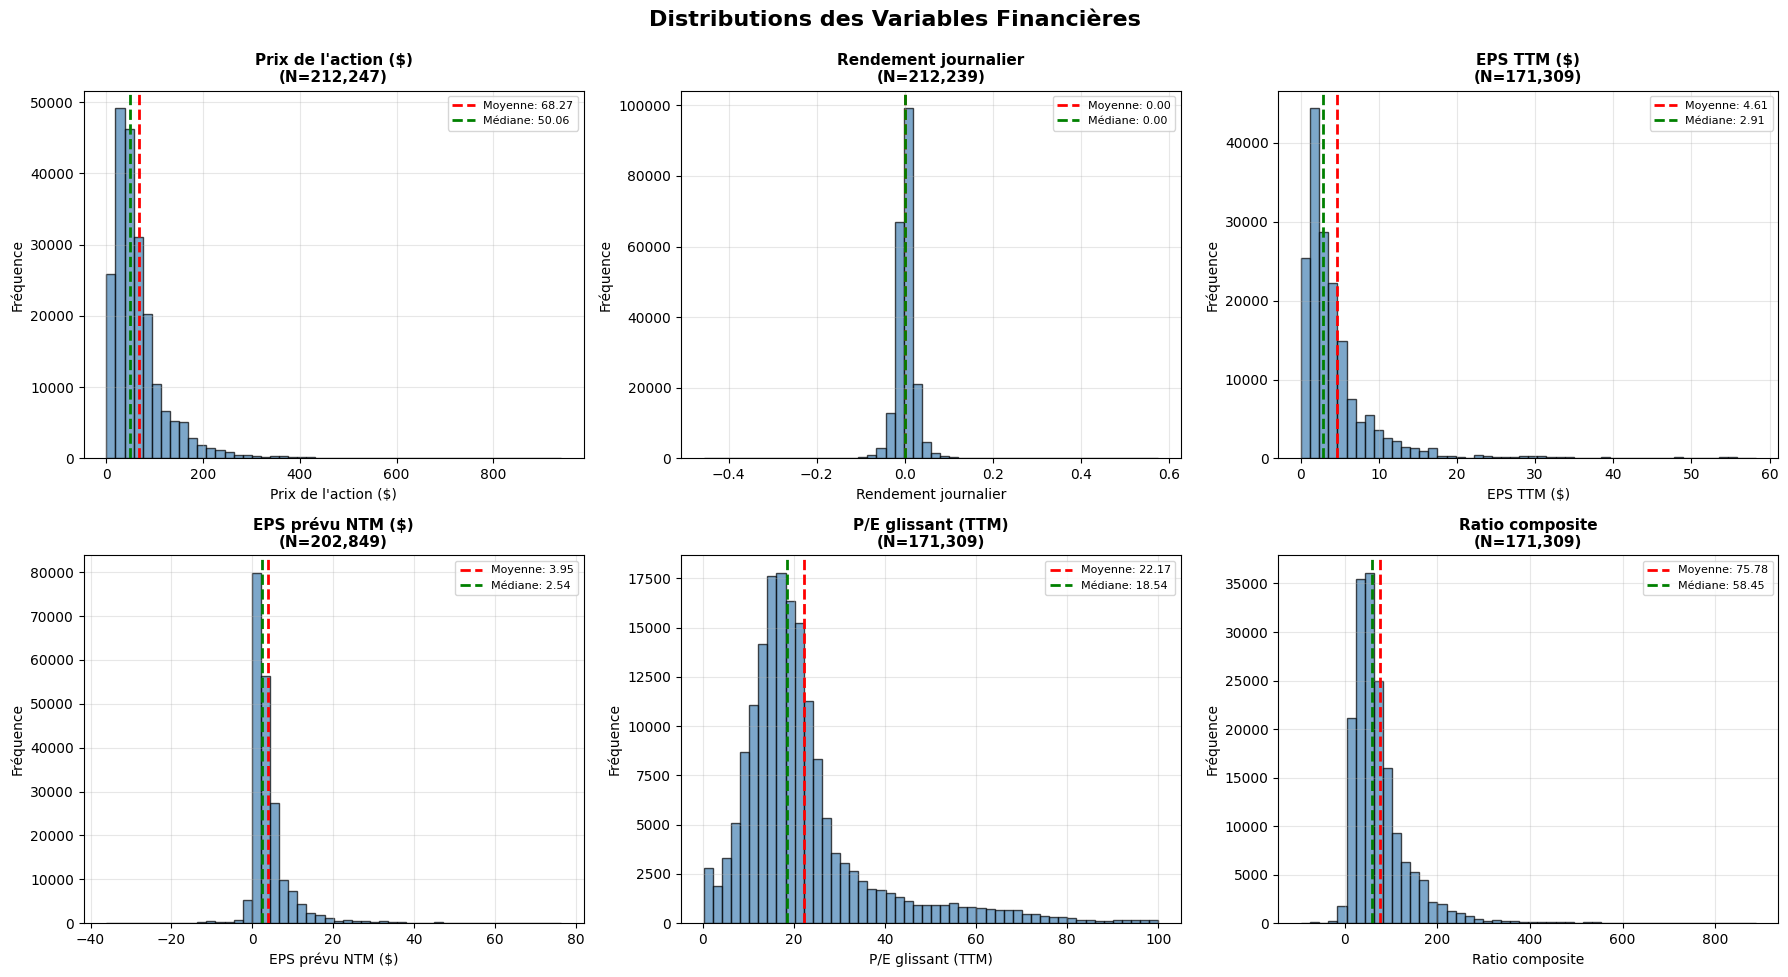

In [126]:
# Étape 11.3: Visualisation des distributions

# Figure avec plusieurs subplots
fig, axes = plt.subplots(3, 3, figsize=(18, 14))
fig.suptitle('Distributions des Variables Financières', fontsize=16, fontweight='bold', y=0.995)

# Liste des variables 
plot_vars = [
    ('price', 'Prix de l\'action ($)'),
    ('ret', 'Rendement journalier'),
    ('ttm_eps', 'EPS TTM ($)'),
    ('forecast_eps_ntm', 'EPS prévu NTM ($)'),
    ('TTM_PE', 'P/E glissant (TTM)'),
    ('Composite_Ratio', 'Ratio composite'),
]

# Histogrammes
for idx, (var_col, var_name) in enumerate(plot_vars):
    if var_col in stats_data.columns:
        row = idx // 3
        col = idx % 3
        ax = axes[row, col]
        
        data = stats_data[var_col].dropna()
        
        if len(data) > 0:
            # Histogramme
            ax.hist(data, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
            ax.set_xlabel(var_name, fontsize=10)
            ax.set_ylabel('Fréquence', fontsize=10)
            ax.set_title(f'{var_name}\n(N={len(data):,})', fontsize=11, fontweight='bold')
            ax.grid(True, alpha=0.3)
            
            # Statistiques sur le graphique
            mean_val = data.mean()
            median_val = data.median()
            ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Moyenne: {mean_val:.2f}')
            ax.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Médiane: {median_val:.2f}')
            ax.legend(fontsize=8, loc='upper right')

# Créer un Q-Q plot pour les rendements
ax = axes[2, 0]
if 'ret' in stats_data.columns:
    ret_data = stats_data['ret'].dropna()
    if len(ret_data) > 0:
        probplot(ret_data, dist="norm", plot=ax)
        ax.set_title('Q-Q Plot: Rendements\nvs. Distribution Normale', fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.3)

# Masquer axes inutilisés
for i in range(len(plot_vars), 9):
    row = i // 3
    col = i % 3
    axes[row, col].set_visible(False)

plt.tight_layout()
plt.show()



In [184]:
# Étape 12: Préparation des séries chronologiques

timeseries_data = stats_data.groupby('date').agg({
    'price': ['mean', 'std'],
    'ret': ['mean', 'std'],
    'ttm_eps': ['mean', 'std'],
    'forecast_eps_ntm': ['mean', 'std'],
    'TTM_PE': ['mean', 'std'],
    'Composite_Ratio': ['mean', 'std']
}).reset_index()

timeseries_data.columns = [
    'date',
    'price_mean', 'price_std',
    'ret_mean', 'ret_std',
    'ttm_eps_mean', 'ttm_eps_std',
    'forecast_eps_mean', 'forecast_eps_std',
    'ttm_pe_mean', 'ttm_pe_std',
    'composite_mean', 'composite_std'
]

timeseries_data


,date,price_mean,price_std,ret_mean,ret_std,ttm_eps_mean,ttm_eps_std,forecast_eps_mean,forecast_eps_std,ttm_pe_mean,ttm_pe_std,composite_mean,composite_std
0,2003-01-02,29.8684,16.3394,0.0291,0.0221,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>
1,2003-01-03,29.6129,16.3338,-0.0100,0.0373,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>
2,2003-01-06,30.1779,16.5881,0.0218,0.0271,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>
3,2003-01-07,29.8352,16.3943,-0.0105,0.0266,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>
4,2003-01-08,29.3360,16.0279,-0.0144,0.0160,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5280,2023-12-22,142.4571,149.0775,0.0043,0.0071,8.4799,8.9399,8.0263,8.3203,24.1780,19.6193,144.9189,150.8900
5281,2023-12-26,143.1014,149.2991,0.0074,0.0100,8.4799,8.9399,8.0263,8.3203,24.2974,19.6621,145.5213,151.0177
5282,2023-12-27,143.1774,149.7370,0.0003,0.0053,8.4799,8.9399,8.0263,8.3203,24.3103,19.6860,145.6043,151.4852
5283,2023-12-28,142.9663,148.9788,0.0026,0.0130,8.4799,8.9399,8.0263,8.3203,24.3337,19.7056,145.3975,150.7495


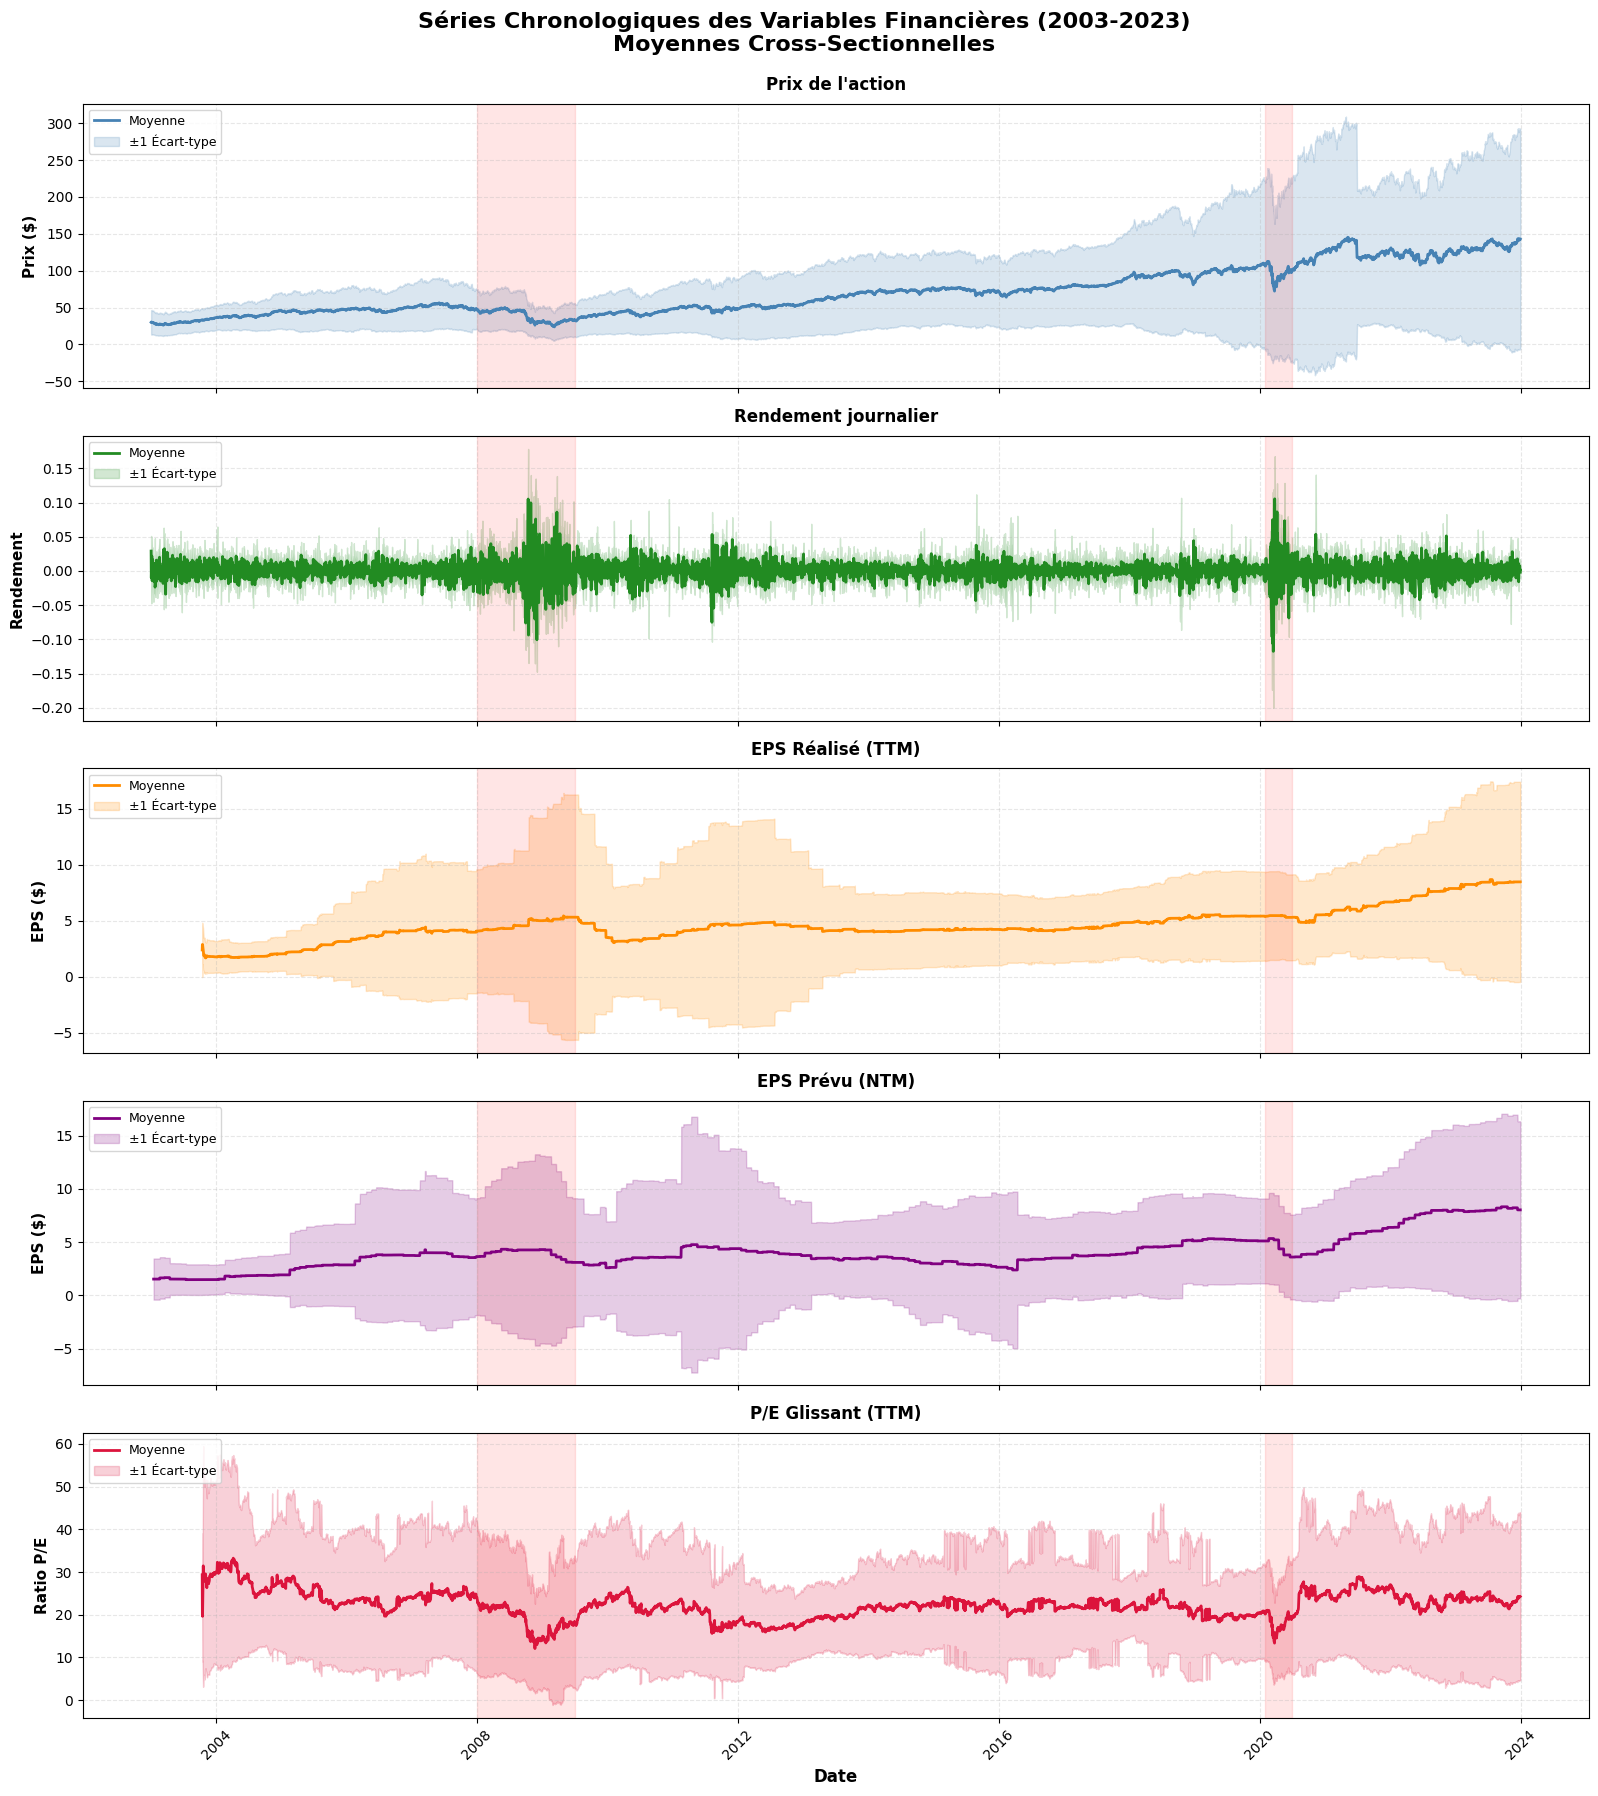

In [128]:
# Étape 12.2: Graphiques de séries chronologiques (5 panneaux)

fig, axes = plt.subplots(5, 1, figsize=(16, 18), sharex=True)
fig.suptitle('Séries Chronologiques des Variables Financières (2003-2023)\nMoyennes Cross-Sectionnelles', 
             fontsize=16, fontweight='bold', y=0.995)

# Définir variables 
plots_config = [
    ('price_mean', 'price_std', 'Prix de l\'action', 'Prix ($)', 'steelblue'),
    ('ret_mean', 'ret_std', 'Rendement journalier', 'Rendement', 'forestgreen'),
    ('ttm_eps_mean', 'ttm_eps_std', 'EPS Réalisé (TTM)', 'EPS ($)', 'darkorange'),
    ('forecast_eps_mean', 'forecast_eps_std', 'EPS Prévu (NTM)', 'EPS ($)', 'purple'),
    ('ttm_pe_mean', 'ttm_pe_std', 'P/E Glissant (TTM)', 'Ratio P/E', 'crimson'),
]

# Tracer chaque série
for idx, (mean_col, std_col, title, ylabel, color) in enumerate(plots_config):
    ax = axes[idx]
    
    # Filtrer les données non-null
    plot_data = timeseries_data[['date', mean_col, std_col]].dropna()
    
    if len(plot_data) > 0:
        # Ligne principale (moyenne)
        ax.plot(plot_data['date'], plot_data[mean_col], 
                color=color, linewidth=2, label='Moyenne')
        
        # Bande d'intervalle de confiance (écart-type)
        ax.fill_between(plot_data['date'],
                        plot_data[mean_col] - plot_data[std_col],
                        plot_data[mean_col] + plot_data[std_col],
                        alpha=0.2, color=color, label='±1 Écart-type')
        
        # Mise en forme
        ax.set_ylabel(ylabel, fontsize=11, fontweight='bold')
        ax.set_title(title, fontsize=12, fontweight='bold', pad=10)
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.legend(loc='upper left', fontsize=9)
        
        # Visualisation crises avec zones rouges
        # 2008
        ax.axvspan(pd.Timestamp('2008-01-01'), pd.Timestamp('2009-06-30'), 
                   alpha=0.1, color='red', label='Crise 2008-09' if idx == 0 else '')
        # 2020
        ax.axvspan(pd.Timestamp('2020-02-01'), pd.Timestamp('2020-06-30'), 
                   alpha=0.1, color='red', label='COVID-19' if idx == 0 else '')
    else:
        ax.text(0.5, 0.5, f'Pas de données pour {title}', 
                ha='center', va='center', transform=ax.transAxes, fontsize=12)

axes[-1].set_xlabel('Date', fontsize=12, fontweight='bold')
axes[-1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()



## Question 2


In [185]:
# Étape 1: Préparation des données pour la régression

# Filtrer pour ne garder que les observations complètes
regression_data = stats_data[['permno', 'ticker', 'date', 'price', 'Composite_Ratio', 'TTM_PE', 'forecast_eps_ntm']].copy()
regression_data = regression_data.dropna()

# FILTRAGE : Garder seulement les observations avec des valorisations positives
regression_data = regression_data[
    (regression_data['price'] > 0) &                   
    (regression_data['Composite_Ratio'] > 0) &         
    (regression_data['TTM_PE'] > 0) &                   
    (regression_data['forecast_eps_ntm'] > 0)           
].copy()

# Enlever les valeurs infinies (sécurité)
regression_data = regression_data[np.isfinite(regression_data['Composite_Ratio'])]
regression_data = regression_data[np.isfinite(regression_data['price'])]

# Filtrer les valeurs extrêmes (winsorisation légère au 1er et 99e percentile)
p1_composite = regression_data['Composite_Ratio'].quantile(0.01)
p99_composite = regression_data['Composite_Ratio'].quantile(0.99)
regression_data = regression_data[
    (regression_data['Composite_Ratio'] >= p1_composite) & 
    (regression_data['Composite_Ratio'] <= p99_composite)
]

print(f"\nObservations totales disponibles: {len(stats_data):,}")
print(f"Observations retenues pour régression: {len(regression_data):,}")
print(f"Tickers uniques: {regression_data['ticker'].nunique()}")

# Statistiques descriptives des variables

summary_stats = pd.DataFrame({
    'Variable': ['Prix observé', 'Prix implicite (EPS×PE)'],
    'N': [len(regression_data), len(regression_data)],
    'Moyenne': [regression_data['price'].mean(), regression_data['Composite_Ratio'].mean()],
    'Écart-type': [regression_data['price'].std(), regression_data['Composite_Ratio'].std()],
    'Min': [regression_data['price'].min(), regression_data['Composite_Ratio'].min()],
    'Médiane': [regression_data['price'].median(), regression_data['Composite_Ratio'].median()],
    'Max': [regression_data['price'].max(), regression_data['Composite_Ratio'].max()]
})

print(summary_stats.round(2).to_string(index=False))



Observations totales disponibles: 212,247
Observations retenues pour régression: 166,965
Tickers uniques: 49
               Variable      N  Moyenne  Écart-type    Min  Médiane      Max
           Prix observé 166965  69.4500     51.1700 4.1400  55.8000 401.6400
Prix implicite (EPS×PE) 166965  72.6900     53.9000 5.4700  58.6700 358.2500


In [186]:
# Étape 2: Estimation de la régression transversale groupée (Pooled Cross-Sectional Regression)

# Préparer les variables pour la régression
Y = regression_data['price'].values  # Variable dépendante
X = regression_data['Composite_Ratio'].values  # Variable explicative

# Convertir en numpy arrays pour éviter les problèmes de type
Y = np.asarray(Y, dtype=float)
X = np.asarray(X, dtype=float)

# Ajouter une constante (intercept)
X_with_const = sm.add_constant(X)

# Estimer le modèle OLS
model = sm.OLS(Y, X_with_const)
results = model.fit()

# Afficher les résultats
print(results.summary())

# Extraire les coefficients clés
beta_0 = results.params[0]  # Intercept
beta_1 = results.params[1]  # Coefficient du prix implicite
r_squared = results.rsquared
r_squared_adj = results.rsquared_adj


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                 2.905e+06
Date:                Thu, 27 Nov 2025   Prob (F-statistic):               0.00
Time:                        09:37:05   Log-Likelihood:            -6.5082e+05
No. Observations:              166965   AIC:                         1.302e+06
Df Residuals:                  166963   BIC:                         1.302e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3360      0.049     47.658      0.0

In [188]:
# Étape 3: Analyse des résidus

# Calculer les résidus
residuals = results.resid
fitted_values = results.fittedvalues

# Ajouter les résidus au DataFrame
regression_data['fitted_price'] = fitted_values
regression_data['residuals'] = residuals
regression_data['residuals_pct'] = (residuals / regression_data['price']) * 100

# Statistiques sommaires des résidus

residual_stats = pd.DataFrame({
    'Métrique': [
        'Nombre d\'observations',
        'Moyenne',
        'Médiane',
        'Écart-type',
        'Min',
        'Q1 (25%)',
        'Q3 (75%)',
        'Max',
        'Skewness',
        'Kurtosis'
    ],
    'Résidus ($)': [
        len(residuals),
        residuals.mean(),
        np.median(residuals),
        residuals.std(),
        residuals.min(),
        np.percentile(residuals, 25),
        np.percentile(residuals, 75),
        residuals.max(),
        skew(residuals),
        kurtosis(residuals)
    ],
    'Résidus (%)': [
        len(regression_data['residuals_pct']),
        regression_data['residuals_pct'].mean(),
        regression_data['residuals_pct'].median(),
        regression_data['residuals_pct'].std(),
        regression_data['residuals_pct'].min(),
        np.percentile(regression_data['residuals_pct'], 25),
        np.percentile(regression_data['residuals_pct'], 75),
        regression_data['residuals_pct'].max(),
        skew(regression_data['residuals_pct']),
        kurtosis(regression_data['residuals_pct'])
    ]
})

print(residual_stats.round(4).to_string(index=False))

# Erreur absolue moyenne (MAE) et RMSE
mae = np.abs(residuals).mean()
rmse = np.sqrt((residuals**2).mean())
mape = np.abs(regression_data['residuals_pct']).mean()

print(f"MAE (Mean Absolute Error)        : ${mae:,.2f}")
print(f"RMSE (Root Mean Squared Error)   : ${rmse:,.2f}")
print(f"MAPE (Mean Absolute % Error)     : {mape:.2f}%")

# Proportion des résidus dans différents intervalles
within_5pct = (np.abs(regression_data['residuals_pct']) <= 5).sum() / len(regression_data) * 100
within_10pct = (np.abs(regression_data['residuals_pct']) <= 10).sum() / len(regression_data) * 100
within_20pct = (np.abs(regression_data['residuals_pct']) <= 20).sum() / len(regression_data) * 100

print(f"Observations avec erreur ≤ 5%  : {within_5pct:.1f}%")
print(f"Observations avec erreur ≤ 10% : {within_10pct:.1f}%")
print(f"Observations avec erreur ≤ 20% : {within_20pct:.1f}%")


             Métrique  Résidus ($)  Résidus (%)
Nombre d'observations 166,965.0000 166,965.0000
              Moyenne      -0.0000      -3.3512
              Médiane      -0.0422      -0.0755
           Écart-type      11.9294      23.9756
                  Min    -224.9308    -369.6541
             Q1 (25%)      -2.9960      -7.0913
             Q3 (75%)       3.6805       5.1639
                  Max      97.5992      74.6622
             Skewness      -2.7353      -5.2050
             Kurtosis      31.7562      51.3211
MAE (Mean Absolute Error)        : $6.44
RMSE (Root Mean Squared Error)   : $11.93
MAPE (Mean Absolute % Error)     : 11.85%
Observations avec erreur ≤ 5%  : 43.8%
Observations avec erreur ≤ 10% : 67.9%
Observations avec erreur ≤ 20% : 85.6%


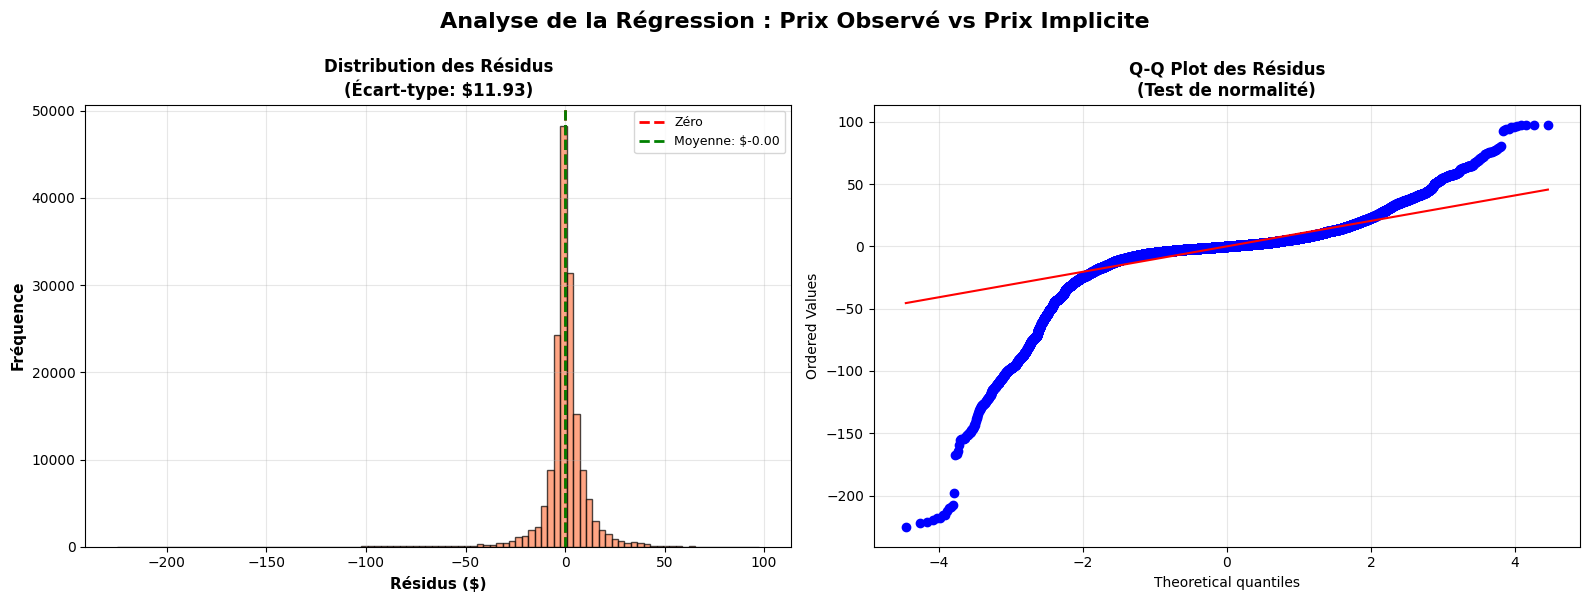

In [190]:
# Étape 4: Visualisations de la régression

# Créer une figure avec 2 sous-graphiques côte à côte
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Analyse de la Régression : Prix Observé vs Prix Implicite', 
             fontsize=16, fontweight='bold', y=0.995)

# 1. Distribution des résidus
ax2 = axes[0]  # Premier graphique (au lieu de axes[0, 0])
ax2.hist(residuals, bins=100, alpha=0.7, color='coral', edgecolor='black')
ax2.axvline(0, color='red', linestyle='--', linewidth=2, label='Zéro')
ax2.axvline(residuals.mean(), color='green', linestyle='--', linewidth=2, 
            label=f'Moyenne: ${residuals.mean():.2f}')
ax2.set_xlabel('Résidus ($)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Fréquence', fontsize=11, fontweight='bold')
ax2.set_title(f'Distribution des Résidus\n(Écart-type: ${residuals.std():.2f})', 
              fontsize=12, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# 2. Q-Q Plot des résidus (test de normalité)
ax4 = axes[1]  # Deuxième graphique (au lieu de axes[0, 1])
probplot(residuals, dist="norm", plot=ax4)
ax4.set_title('Q-Q Plot des Résidus\n(Test de normalité)', 
              fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# Modèle naïf (i) : Prix sur P/E glissant seul

# Préparer les données pour ce modèle
model1_data = regression_data[['price', 'TTM_PE']].copy()

# Variables pour la régression
Y_model1 = np.asarray(model1_data['price'].values, dtype=float)
X_model1 = np.asarray(model1_data['TTM_PE'].values, dtype=float)

# Ajouter une constante
X_model1_const = sm.add_constant(X_model1)

# Estimer le modèle
model1 = sm.OLS(Y_model1, X_model1_const)
results1 = model1.fit()

# Extraire les résultats
beta_0_m1 = results1.params[0]
beta_1_m1 = results1.params[1]
r_squared_m1 = results1.rsquared
r_squared_adj_m1 = results1.rsquared_adj


print(f"BETA 0 (Constante)      : {beta_0_m1:10.4f}  (t-stat: {results1.tvalues[0]:8.2f})")
print(f"BETA 1 (P/E TTM)        : {beta_1_m1:10.4f}  (t-stat: {results1.tvalues[1]:8.2f})")
print(f"\nR^2                   : {r_squared_m1:.4f}")
print(f"R^2 ajusté              : {r_squared_adj_m1:.4f}")
print(f"Nombre d'obs.           : {int(results1.nobs):,}")

print(" ")

print(f"Modèle de base (EPS × P/E) : R^2 = {r_squared:.4f}")
print(f"Modèle naïf (P/E seul)     : R^2 = {r_squared_m1:.4f}")
print(f"Différence                 : ΔR^2 = {r_squared - r_squared_m1:.4f}")
print(f"Perte relative             : {((r_squared - r_squared_m1) / r_squared * 100):.2f}%")

BETA 0 (Constante)      :    66.8349  (t-stat:   297.55)
BETA 1 (P/E TTM)        :     0.1170  (t-stat:    14.00)

R^2                   : 0.0012
R^2 ajusté              : 0.0012
Nombre d'obs.           : 166,965
 
Modèle de base (EPS × P/E) : R^2 = 0.9457
Modèle naïf (P/E seul)     : R^2 = 0.0012
Différence                 : ΔR^2 = 0.9445
Perte relative             : 99.88%

✓ Modèle (i) estimé


In [ ]:
# Modèle naïf (ii) : Prix sur EPS prévu seul

# Préparer les données pour ce modèle
model2_data = regression_data[['price', 'forecast_eps_ntm']].copy()

# Variables pour la régression
Y_model2 = np.asarray(model2_data['price'].values, dtype=float)
X_model2 = np.asarray(model2_data['forecast_eps_ntm'].values, dtype=float)

# Ajouter une constante
X_model2_const = sm.add_constant(X_model2)

# Estimer le modèle
model2 = sm.OLS(Y_model2, X_model2_const)
results2 = model2.fit()

# Extraire les résultats
beta_0_m2 = results2.params[0]
beta_1_m2 = results2.params[1]
r_squared_m2 = results2.rsquared
r_squared_adj_m2 = results2.rsquared_adj

print(f"BETA 0 (Constante)      : {beta_0_m2:10.4f}  (t-stat: {results2.tvalues[0]:8.2f})")
print(f"BETA 1 (EPS prévu)      : {beta_1_m2:10.4f}  (t-stat: {results2.tvalues[1]:8.2f})")
print(f"\nR^2                   : {r_squared_m2:.4f}")
print(f"R^2 ajusté              : {r_squared_adj_m2:.4f}")
print(f"Nombre d'obs.           : {int(results2.nobs):,}")

print(" ")
print(f"Modèle de base (EPS × P/E) : R^2 = {r_squared:.4f}")
print(f"Modèle naïf (EPS seul)     : R^2 = {r_squared_m2:.4f}")
print(f"Différence                 : ΔR^2 = {r_squared - r_squared_m2:.4f}")
print(f"Perte relative             : {((r_squared - r_squared_m2) / r_squared * 100):.2f}%")

BETA 0 (Constante)      :    51.0963  (t-stat:   348.57)
BETA 1 (EPS prévu)      :     3.9796  (t-stat:   196.24)

R^2                   : 0.1874
R^2 ajusté              : 0.1874
Nombre d'obs.           : 166,965
 
Modèle de base (EPS × P/E) : R^2 = 0.9457
Modèle naïf (EPS seul)     : R^2 = 0.1874
Différence                 : ΔR^2 = 0.7582
Perte relative             : 80.18%

✓ Modèle (ii) estimé


In [200]:
# Tableau comparatif des trois modèles

# Créer un DataFrame comparatif
comparison_df = pd.DataFrame({
    'Modèle': [
        'Modèle de base: Prix ~ (EPS × P/E)',
        'Modèle naïf (i): Prix ~ P/E_TTM',
        'Modèle naïf (ii): Prix ~ EPS_prévu'
    ],
    'Variable(s) explicative(s)': [
        'EPS_prévu × P/E_TTM',
        'P/E_TTM seul',
        'EPS_prévu seul'
    ],
    'R²': [
        r_squared,
        r_squared_m1,
        r_squared_m2
    ],
    'R² ajusté': [
        r_squared_adj,
        r_squared_adj_m1,
        r_squared_adj_m2
    ]
})

# Ajouter la différence de R² par rapport au modèle de base
comparison_df['ΔR² vs base'] = comparison_df['R²'] - r_squared
comparison_df['Perte relative (%)'] = ((r_squared - comparison_df['R²']) / r_squared * 100)

# Afficher le tableau
print("\n")
for i, row in comparison_df.iterrows():
    print(f"\n{row['Modèle']}")
    print(f"  Variable(s)       : {row['Variable(s) explicative(s)']}")
    print(f"  R²                : {row['R²']:.4f}")
    print(f"  R² ajusté         : {row['R² ajusté']:.4f}")
    if i > 0:  # Ne pas afficher pour le modèle de base
        print(f"  ΔR² vs base       : {row['ΔR² vs base']:.4f}")
        print(f"  Perte relative    : {row['Perte relative (%)']:.2f}%")

# Calculer le R² moyen des modèles naïfs
r_squared_naive_avg = (r_squared_m1 + r_squared_m2) / 2
r_squared_improvement = r_squared - r_squared_naive_avg




Modèle de base: Prix ~ (EPS × P/E)
  Variable(s)       : EPS_prévu × P/E_TTM
  R²                : 0.9457
  R² ajusté         : 0.9457

Modèle naïf (i): Prix ~ P/E_TTM
  Variable(s)       : P/E_TTM seul
  R²                : 0.0012
  R² ajusté         : 0.0012
  ΔR² vs base       : -0.9445
  Perte relative    : 99.88%

Modèle naïf (ii): Prix ~ EPS_prévu
  Variable(s)       : EPS_prévu seul
  R²                : 0.1874
  R² ajusté         : 0.1874
  ΔR² vs base       : -0.7582
  Perte relative    : 80.18%


In [201]:
# Préparation des données pour les prévisions à une période d'avance

# Trier les données par ticker et date pour assurer l'ordre chronologique
forecast_data = regression_data.copy()
forecast_data = forecast_data.sort_values(['ticker', 'date']).reset_index(drop=True)

# Créer un identifiant pour chaque observation
forecast_data['obs_id'] = range(len(forecast_data))

# Définir la fenêtre minimale pour l'estimation initiale
min_window = 1000 

In [202]:
# Générer les prévisions à une période d'avance avec fenêtre expansive (expanding window)

# Initialiser les arrays pour stocker les prévisions
n_obs = len(forecast_data)
predictions_base = np.full(n_obs, np.nan)
predictions_m1 = np.full(n_obs, np.nan)
predictions_m2 = np.full(n_obs, np.nan)

# Pour accélérer, on peut faire des prévisions tous les N jours au lieu de chaque jour
# Ici, on fera une approche simplifiée : estimer sur 80% des données, prédire sur 20%
split_point = int(len(forecast_data) * 0.8)

print(f"\nApproche simplifiée (split temporel) :")
print(f"  Période d'estimation : Observations 1 à {split_point:,}")
print(f"  Période de prévision : Observations {split_point+1:,} à {n_obs:,}")
print(f"  Nombre de prévisions : {n_obs - split_point:,}")

# Diviser les données
train_data = forecast_data.iloc[:split_point].copy()
test_data = forecast_data.iloc[split_point:].copy()

# Modèle de base : Prix ~ (EPS × P/E)
Y_train_base = np.asarray(train_data['price'].values, dtype=float)
X_train_base = np.asarray(train_data['Composite_Ratio'].values, dtype=float)
X_train_base_const = sm.add_constant(X_train_base)
model_base_train = sm.OLS(Y_train_base, X_train_base_const).fit()

# Modèle naïf (i) : Prix ~ P/E_TTM
Y_train_m1 = np.asarray(train_data['price'].values, dtype=float)
X_train_m1 = np.asarray(train_data['TTM_PE'].values, dtype=float)
X_train_m1_const = sm.add_constant(X_train_m1)
model_m1_train = sm.OLS(Y_train_m1, X_train_m1_const).fit()

# Modèle naïf (ii) : Prix ~ EPS_prévu
Y_train_m2 = np.asarray(train_data['price'].values, dtype=float)
X_train_m2 = np.asarray(train_data['forecast_eps_ntm'].values, dtype=float)
X_train_m2_const = sm.add_constant(X_train_m2)
model_m2_train = sm.OLS(Y_train_m2, X_train_m2_const).fit()

# Prévisions modèle de base
X_test_base = np.asarray(test_data['Composite_Ratio'].values, dtype=float)
X_test_base_const = sm.add_constant(X_test_base)
test_data['pred_base'] = model_base_train.predict(X_test_base_const)

# Prévisions modèle naïf (i)
X_test_m1 = np.asarray(test_data['TTM_PE'].values, dtype=float)
X_test_m1_const = sm.add_constant(X_test_m1)
test_data['pred_m1'] = model_m1_train.predict(X_test_m1_const)

# Prévisions modèle naïf (ii)
X_test_m2 = np.asarray(test_data['forecast_eps_ntm'].values, dtype=float)
X_test_m2_const = sm.add_constant(X_test_m2)
test_data['pred_m2'] = model_m2_train.predict(X_test_m2_const)

# Calculer les erreurs de prévision
test_data['error_base'] = test_data['price'] - test_data['pred_base']
test_data['error_m1'] = test_data['price'] - test_data['pred_m1']
test_data['error_m2'] = test_data['price'] - test_data['pred_m2']

# Calculer les erreurs quadratiques
test_data['sq_error_base'] = test_data['error_base']**2
test_data['sq_error_m1'] = test_data['error_m1']**2
test_data['sq_error_m2'] = test_data['error_m2']**2


Approche simplifiée (split temporel) :
  Période d'estimation : Observations 1 à 133,572
  Période de prévision : Observations 133,573 à 166,965
  Nombre de prévisions : 33,393


In [205]:
# Calcul de l'EQMP (Erreur Quadratique Moyenne de Prévision / MSPE)

# Calculer l'EQMP pour chaque modèle
mspe_base = test_data['sq_error_base'].mean()
mspe_m1 = test_data['sq_error_m1'].mean()
mspe_m2 = test_data['sq_error_m2'].mean()

# Calculer la racine de l'EQMP (RMSE de prévision)
rmspe_base = np.sqrt(mspe_base)
rmspe_m1 = np.sqrt(mspe_m1)
rmspe_m2 = np.sqrt(mspe_m2)

# Calculer l'erreur moyenne (biais)
mae_base = test_data['error_base'].abs().mean()
mae_m1 = test_data['error_m1'].abs().mean()
mae_m2 = test_data['error_m2'].abs().mean()

mean_bias_base = test_data['error_base'].mean()
mean_bias_m1 = test_data['error_m1'].mean()
mean_bias_m2 = test_data['error_m2'].mean()

# Créer un DataFrame comparatif
forecast_comparison = pd.DataFrame({
    'Modèle': [
        'Modèle de base (EPS × P/E)',
        'Modèle naïf (i) P/E seul',
        'Modèle naïf (ii) EPS seul'
    ],
    'EQMP': [mspe_base, mspe_m1, mspe_m2],
    'RMSPE ($)': [rmspe_base, rmspe_m1, rmspe_m2],
    'MAE ($)': [mae_base, mae_m1, mae_m2],
    'Biais moyen ($)': [mean_bias_base, mean_bias_m1, mean_bias_m2]
})

# Identifier le meilleur modèle (EQMP le plus faible)
best_model_idx = forecast_comparison['EQMP'].idxmin()
forecast_comparison['Rang'] = forecast_comparison['EQMP'].rank().astype(int)

print("\n")
for i, row in forecast_comparison.iterrows():
    print(f"{row['Modèle']}")
    print(f"  EQMP (MSE)      : {row['EQMP']:12.2f}")
    print(f"  RMSPE           : ${row['RMSPE ($)']:11.2f}")
    print(f"  MAE             : ${row['MAE ($)']:11.2f}")
    print(f"  Biais moyen     : ${row['Biais moyen ($)']:11.2f}")
    print(f"  Rang            : {row['Rang']}")
    if i == best_model_idx:
        print(f"  ★ MEILLEUR MODÈLE (EQMP la plus faible)")
    print()

# Calculer les améliorations relatives
improvement_m1 = ((mspe_m1 - mspe_base) / mspe_m1) * 100
improvement_m2 = ((mspe_m2 - mspe_base) / mspe_m2) * 100

print(f"\nRéduction de l'EQMP par rapport au modèle P/E seul   : {improvement_m1:.2f}%")
print(f"Réduction de l'EQMP par rapport au modèle EPS seul  : {improvement_m2:.2f}%")

best_model_name = forecast_comparison.loc[best_model_idx, 'Modèle']



Modèle de base (EPS × P/E)
  EQMP (MSE)      :        66.48
  RMSPE           : $       8.15
  MAE             : $       4.72
  Biais moyen     : $       0.63
  Rang            : 1
  ★ MEILLEUR MODÈLE (EQMP la plus faible)

Modèle naïf (i) P/E seul
  EQMP (MSE)      :      1684.57
  RMSPE           : $      41.04
  MAE             : $      35.60
  Biais moyen     : $     -21.18
  Rang            : 3

Modèle naïf (ii) EPS seul
  EQMP (MSE)      :      1161.93
  RMSPE           : $      34.09
  MAE             : $      28.00
  Biais moyen     : $     -11.22
  Rang            : 2


Réduction de l'EQMP par rapport au modèle P/E seul   : 96.05%
Réduction de l'EQMP par rapport au modèle EPS seul  : 94.28%


In [209]:
# Métriques additionnelles et tests statistiques

# Calculer l'erreur absolue moyenne en pourcentage (MAPE)
test_data['ape_base'] = (test_data['error_base'].abs() / test_data['price']) * 100
test_data['ape_m1'] = (test_data['error_m1'].abs() / test_data['price']) * 100
test_data['ape_m2'] = (test_data['error_m2'].abs() / test_data['price']) * 100

mape_base = test_data['ape_base'].mean()
mape_m1 = test_data['ape_m1'].mean()
mape_m2 = test_data['ape_m2'].mean()

# Calculer le coefficient de détermination hors-échantillon (R² de prévision)
ss_total = ((test_data['price'] - test_data['price'].mean())**2).sum()
ss_res_base = (test_data['error_base']**2).sum()
ss_res_m1 = (test_data['error_m1']**2).sum()
ss_res_m2 = (test_data['error_m2']**2).sum()

r2_oos_base = 1 - (ss_res_base / ss_total)
r2_oos_m1 = 1 - (ss_res_m1 / ss_total)
r2_oos_m2 = 1 - (ss_res_m2 / ss_total)

metrics_df = pd.DataFrame({
    'Modèle': [
        'Base (EPS × P/E)',
        'Naïf (i) P/E',
        'Naïf (ii) EPS'
    ],
    'EQMP': [mspe_base, mspe_m1, mspe_m2],
    'RMSPE ($)': [rmspe_base, rmspe_m1, rmspe_m2],
    'MAE ($)': [mae_base, mae_m1, mae_m2],
    'MAPE (%)': [mape_base, mape_m1, mape_m2],
    'R² OOS': [r2_oos_base, r2_oos_m1, r2_oos_m2]
})

print("\n")
print(metrics_df.to_string(index=False))

# Test de Diebold-Mariano pour comparer la précision des prévisions
# Différence des erreurs quadratiques
diff_base_m1 = test_data['sq_error_base'] - test_data['sq_error_m1']
diff_base_m2 = test_data['sq_error_base'] - test_data['sq_error_m2']

# Test t simple pour la différence moyenne
from scipy import stats as scipy_stats

# Base vs Naïf (i)
t_stat_1, p_value_1 = scipy_stats.ttest_rel(test_data['sq_error_base'], test_data['sq_error_m1'])

# Base vs Naïf (ii)
t_stat_2, p_value_2 = scipy_stats.ttest_rel(test_data['sq_error_base'], test_data['sq_error_m2'])



          Modèle       EQMP  RMSPE ($)  MAE ($)  MAPE (%)  R² OOS
Base (EPS × P/E)    66.4788     8.1535   4.7155   10.8223  0.9462
    Naïf (i) P/E 1,684.5668    41.0435  35.6016  121.7858 -0.3627
   Naïf (ii) EPS 1,161.9265    34.0870  27.9979   91.2951  0.0601


In [ ]:
# Sélection d'une entreprise représentative et préparation des données

# Calculer les statistiques par entreprise
company_forecast_stats = regression_data.groupby('ticker').agg({
    'price': 'count',
    'date': ['min', 'max']
}).reset_index()

company_forecast_stats.columns = ['ticker', 'n_obs', 'date_min', 'date_max']
company_forecast_stats = company_forecast_stats.sort_values('n_obs', ascending=False)

print("\nTop 10 entreprises par nombre d'observations :")
print(company_forecast_stats.head(10).to_string(index=False))

selected_ticker = 'UNH'

# Alternative (pour autre échantillon)
if selected_ticker not in regression_data['ticker'].unique():
    selected_ticker = company_forecast_stats.iloc[0]['ticker']

# Extraire les données pour cette entreprise
company_data = regression_data[regression_data['ticker'] == selected_ticker].copy()
company_data = company_data.sort_values('date').reset_index(drop=True)

# Générer les prévisions avec le modèle de base (utiliser les coefficients estimés)
company_data['predicted_price'] = beta_0 + beta_1 * company_data['Composite_Ratio']

# Calculer les résidus
company_data['residual'] = company_data['price'] - company_data['predicted_price']

print(f"\nRMSE pour {selected_ticker} : ${company_data['residual'].std():.2f}")
print(f"MAPE pour {selected_ticker} : {(company_data['residual'].abs() / company_data['price']).mean() * 100:.2f}%")


Top 10 entreprises par nombre d'observations :
ticker  n_obs   date_min   date_max
   IBM   5087 2003-10-15 2023-12-29
   GPC   5086 2003-10-16 2023-12-29
  CHRW   5083 2003-10-21 2023-12-29
   SNA   5082 2003-10-22 2023-12-29
    VZ   5078 2003-10-28 2023-12-29
   WMI   5076 2003-10-30 2023-12-29
   LNT   5076 2003-10-30 2023-12-29
   PRU   5073 2003-11-04 2023-12-29
   CLX   5071 2003-11-06 2023-12-29
    WR   5069 2003-11-10 2023-12-29

RMSE pour IBM : $8.84
MAPE pour IBM : 5.24%

✓ Données préparées pour l'entreprise sélectionnée


In [211]:
# Calcul des intervalles de confiance à 95%

se_prediction = np.sqrt(results.mse_resid)  # Erreur standard des résidus du modèle global

print(f"\nErreur standard de prévision (globale) : ${se_prediction:.2f}")

# Intervalle de confiance à 95% : ± 1.96 × SE
z_95 = 1.96

company_data['ci_lower'] = company_data['predicted_price'] - z_95 * se_prediction
company_data['ci_upper'] = company_data['predicted_price'] + z_95 * se_prediction

# Vérifier si les prix réels sont dans l'IC 95%
company_data['in_ci'] = (
    (company_data['price'] >= company_data['ci_lower']) & 
    (company_data['price'] <= company_data['ci_upper'])
)

coverage_rate = company_data['in_ci'].mean() * 100

print(f"\nTaux de couverture observé  : {coverage_rate:.2f}%")
print(f"Taux de couverture attendu  : 95.00%")
print(f"Différence                  : {coverage_rate - 95:.2f} points de pourcentage")

# Largeur moyenne de l'IC
avg_ci_width = (company_data['ci_upper'] - company_data['ci_lower']).mean()
print(f"\nLargeur moyenne de l'IC     : ${avg_ci_width:.2f}")
print(f"Largeur relative (% prix)   : {(avg_ci_width / company_data['price'].mean()) * 100:.2f}%")

# Statistiques des résidus pour cette entreprise
print(f"\nMoyenne des résidus         : ${company_data['residual'].mean():.2f}")
print(f"Écart-type des résidus      : ${company_data['residual'].std():.2f}")
print(f"MAE                         : ${company_data['residual'].abs().mean():.2f}")
print(f"MAPE                        : {(company_data['residual'].abs() / company_data['price']).mean() * 100:.2f}%")


Erreur standard de prévision (globale) : $11.93

Taux de couverture observé  : 96.85%
Taux de couverture attendu  : 95.00%
Différence                  : 1.85 points de pourcentage

Largeur moyenne de l'IC     : $46.76
Largeur relative (% prix)   : 34.34%

Moyenne des résidus         : $3.19
Écart-type des résidus      : $8.84
MAE                         : $7.07
MAPE                        : 5.24%


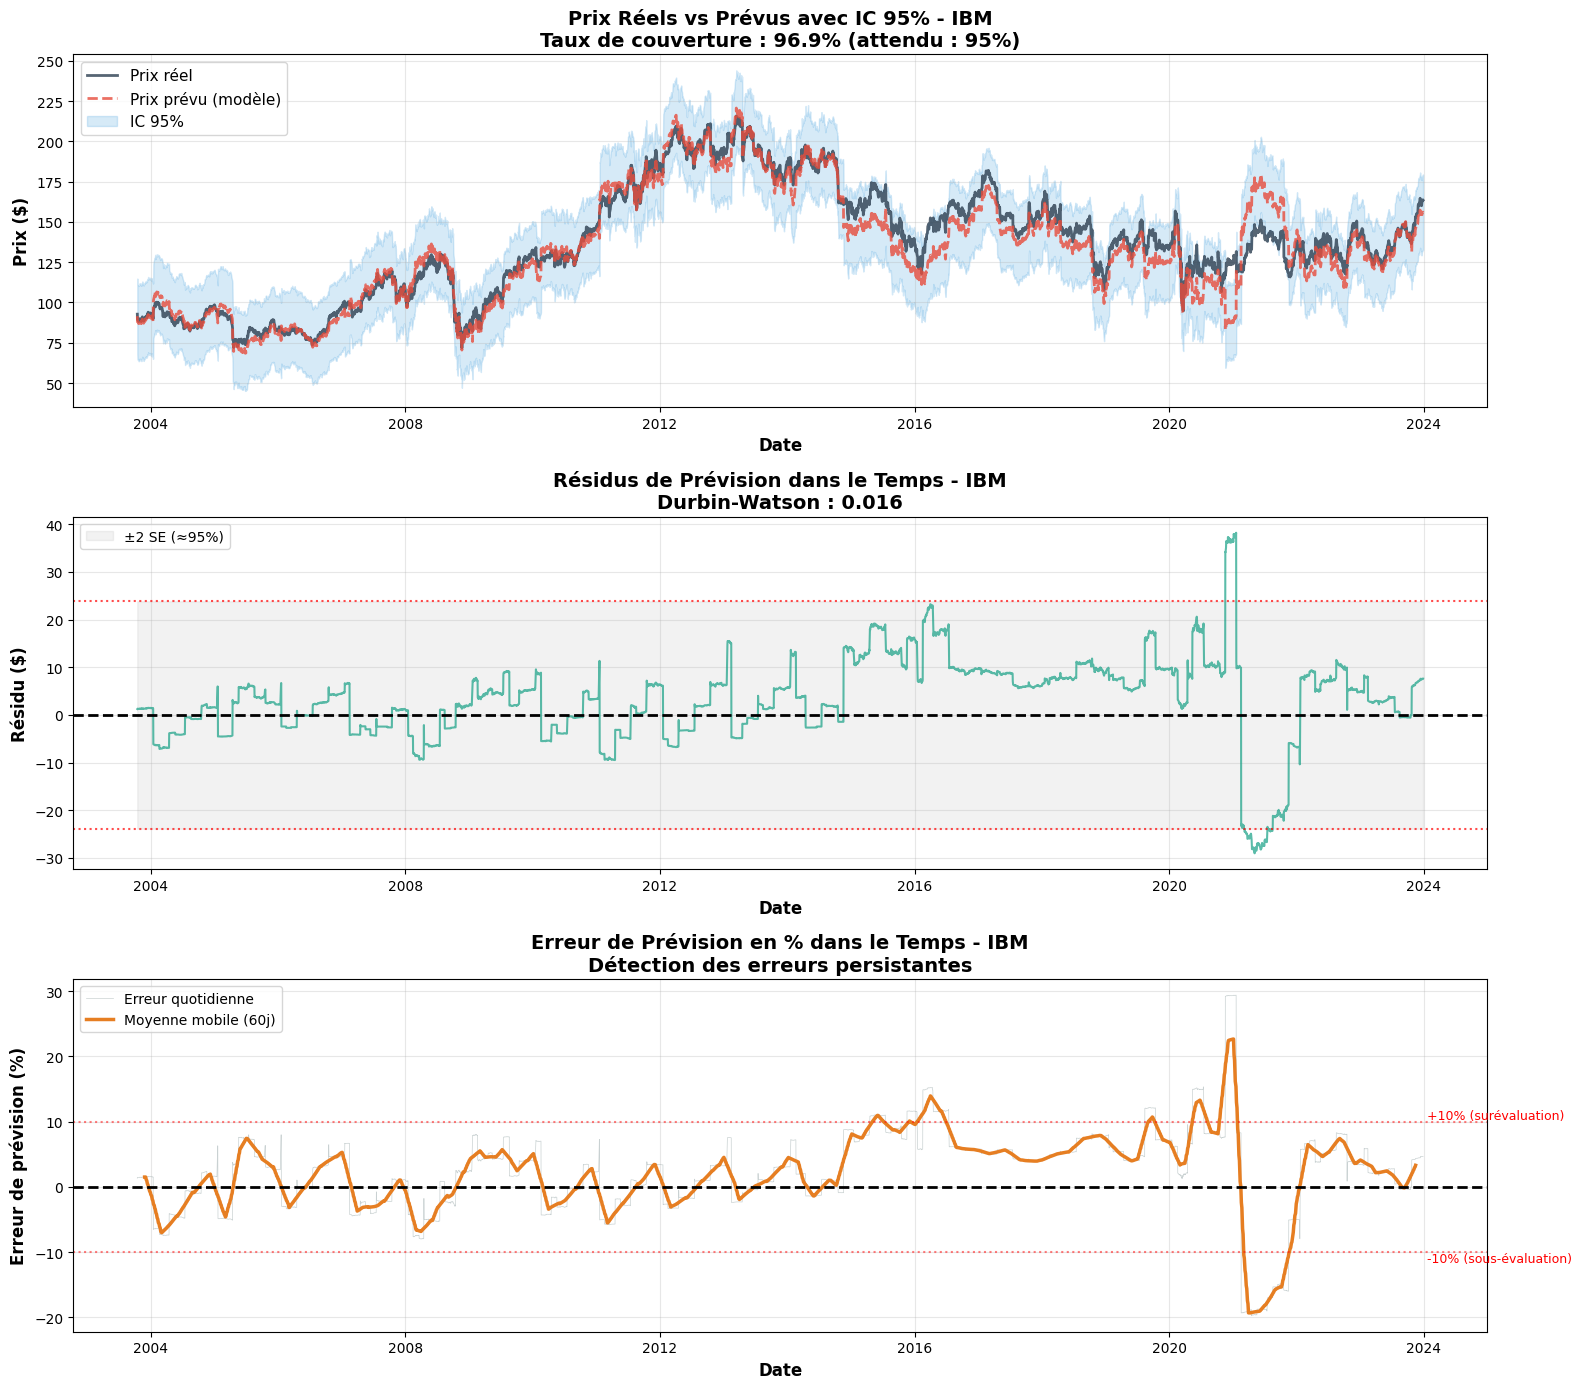

In [213]:
# Graphique de série chronologique avec intervalles de confiance

fig, axes = plt.subplots(3, 1, figsize=(16, 14))

# Graphique 1 : Série chronologique complète

ax1 = axes[0]

# Prix réel
ax1.plot(company_data['date'], company_data['price'], 
         label='Prix réel', color='#2c3e50', linewidth=2, alpha=0.8)

# Prix prévu
ax1.plot(company_data['date'], company_data['predicted_price'], 
         label='Prix prévu (modèle)', color='#e74c3c', linewidth=2, linestyle='--', alpha=0.8)

# Intervalle de confiance à 95%
ax1.fill_between(company_data['date'], 
                  company_data['ci_lower'], 
                  company_data['ci_upper'],
                  alpha=0.2, color='#3498db', label='IC 95%')

ax1.set_xlabel('Date', fontsize=12, fontweight='bold')
ax1.set_ylabel('Prix ($)', fontsize=12, fontweight='bold')
ax1.set_title(f'Prix Réels vs Prévus avec IC 95% - {selected_ticker}\n' + 
              f'Taux de couverture : {coverage_rate:.1f}% (attendu : 95%)',
              fontsize=14, fontweight='bold')
ax1.legend(loc='upper left', fontsize=11)
ax1.grid(alpha=0.3)

# Graphique 2 : Résidus dans le temps

ax2 = axes[1]

ax2.plot(company_data['date'], company_data['residual'], 
         color='#16a085', linewidth=1.5, alpha=0.7)
ax2.axhline(y=0, color='black', linestyle='--', linewidth=2)

# Bandes à ± 2 SE (environ 95% des résidus devraient être dans cette bande)
ax2.axhline(y=2*se_prediction, color='red', linestyle=':', linewidth=1.5, alpha=0.7)
ax2.axhline(y=-2*se_prediction, color='red', linestyle=':', linewidth=1.5, alpha=0.7)
ax2.fill_between(company_data['date'], -2*se_prediction, 2*se_prediction,
                  alpha=0.1, color='gray', label='±2 SE (≈95%)')

ax2.set_xlabel('Date', fontsize=12, fontweight='bold')
ax2.set_ylabel('Résidu ($)', fontsize=12, fontweight='bold')
ax2.set_title(f'Résidus de Prévision dans le Temps - {selected_ticker}\n' +
              f'Durbin-Watson : {dw_stat:.3f}',
              fontsize=14, fontweight='bold')
ax2.legend(loc='upper left', fontsize=10)
ax2.grid(alpha=0.3)

# Graphique 3 : Erreur de prévision en pourcentage (rolling)

ax3 = axes[2]

# Calculer l'erreur en pourcentage
company_data['pct_error'] = (company_data['residual'] / company_data['price']) * 100

# Moyenne mobile des erreurs pour voir les tendances persistantes
window = 60  
company_data['pct_error_ma'] = company_data['pct_error'].rolling(window=window, center=True).mean()

ax3.plot(company_data['date'], company_data['pct_error'], 
         color='#95a5a6', linewidth=0.5, alpha=0.5, label='Erreur quotidienne')
ax3.plot(company_data['date'], company_data['pct_error_ma'], 
         color='#e67e22', linewidth=2.5, label=f'Moyenne mobile ({window}j)')
ax3.axhline(y=0, color='black', linestyle='--', linewidth=2)

ax3.set_xlabel('Date', fontsize=12, fontweight='bold')
ax3.set_ylabel('Erreur de prévision (%)', fontsize=12, fontweight='bold')
ax3.set_title(f'Erreur de Prévision en % dans le Temps - {selected_ticker}\n' +
              f'Détection des erreurs persistantes',
              fontsize=14, fontweight='bold')
ax3.legend(loc='upper left', fontsize=10)
ax3.grid(alpha=0.3)

# Identifier les périodes d'erreurs persistantes
if company_data['pct_error_ma'].max() > 10:
    ax3.axhline(y=10, color='red', linestyle=':', alpha=0.5)
    ax3.text(company_data['date'].iloc[-1], 10, ' +10% (surévaluation)', 
             fontsize=9, color='red', va='bottom')
if company_data['pct_error_ma'].min() < -10:
    ax3.axhline(y=-10, color='red', linestyle=':', alpha=0.5)
    ax3.text(company_data['date'].iloc[-1], -10, ' -10% (sous-évaluation)', 
             fontsize=9, color='red', va='top')

plt.tight_layout()
plt.show()

## Question 3

In [227]:
# Création des prédicteurs enrichis pour l'apprentissage automatique

ml_data = regression_data.copy()

# Fusionner avec les rendements depuis stats_data
ml_data = ml_data.merge(
    stats_data[['ticker', 'date', 'ret']],
    on=['ticker', 'date'],
    how='left'
)

ml_data = ml_data.sort_values(['ticker', 'date']).reset_index(drop=True)

ml_data

,permno,ticker,date,price,Composite_Ratio,TTM_PE,forecast_eps_ntm,fitted_price,residuals,residuals_pct,ret
0,13056,AM,2003-12-23,21.3000,24.6000,15.0000,1.6400,25.0473,-3.7473,-17.5930,-0.0567
1,13056,AM,2003-12-24,21.1700,24.4499,14.9085,1.6400,24.9087,-3.7387,-17.6604,-0.0061
2,13056,AM,2003-12-26,21.1300,24.4037,14.8803,1.6400,24.8660,-3.7360,-17.6812,-0.0019
3,13056,AM,2003-12-29,21.3500,24.6577,15.0352,1.6400,25.1006,-3.7506,-17.5673,0.0104
4,13056,AM,2003-12-30,21.6100,24.9580,15.2183,1.6400,25.3779,-3.7679,-17.4357,0.0122
...,...,...,...,...,...,...,...,...,...,...,...
166960,24053,WR,2023-12-22,51.3800,55.5341,21.8638,2.5400,53.6064,-2.2264,-4.3332,0.0061
166961,24053,WR,2023-12-26,51.7900,55.9773,22.0383,2.5400,54.0155,-2.2255,-4.2972,0.0080
166962,24053,WR,2023-12-27,51.8500,56.0421,22.0638,2.5400,54.0754,-2.2254,-4.2920,0.0012
166963,24053,WR,2023-12-28,52.2400,56.4637,22.2298,2.5400,54.4646,-2.2246,-4.2584,0.0075


In [228]:
# 1. VARIABLES DE BASE

ml_data['eps_forecast'] = ml_data['forecast_eps_ntm']
ml_data['pe_ttm'] = ml_data['TTM_PE']
ml_data['eps_times_pe'] = ml_data['Composite_Ratio'] 

ml_data

,permno,ticker,date,price,Composite_Ratio,TTM_PE,forecast_eps_ntm,fitted_price,residuals,residuals_pct,ret,eps_forecast,pe_ttm,eps_times_pe
0,13056,AM,2003-12-23,21.3000,24.6000,15.0000,1.6400,25.0473,-3.7473,-17.5930,-0.0567,1.6400,15.0000,24.6000
1,13056,AM,2003-12-24,21.1700,24.4499,14.9085,1.6400,24.9087,-3.7387,-17.6604,-0.0061,1.6400,14.9085,24.4499
2,13056,AM,2003-12-26,21.1300,24.4037,14.8803,1.6400,24.8660,-3.7360,-17.6812,-0.0019,1.6400,14.8803,24.4037
3,13056,AM,2003-12-29,21.3500,24.6577,15.0352,1.6400,25.1006,-3.7506,-17.5673,0.0104,1.6400,15.0352,24.6577
4,13056,AM,2003-12-30,21.6100,24.9580,15.2183,1.6400,25.3779,-3.7679,-17.4357,0.0122,1.6400,15.2183,24.9580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166960,24053,WR,2023-12-22,51.3800,55.5341,21.8638,2.5400,53.6064,-2.2264,-4.3332,0.0061,2.5400,21.8638,55.5341
166961,24053,WR,2023-12-26,51.7900,55.9773,22.0383,2.5400,54.0155,-2.2255,-4.2972,0.0080,2.5400,22.0383,55.9773
166962,24053,WR,2023-12-27,51.8500,56.0421,22.0638,2.5400,54.0754,-2.2254,-4.2920,0.0012,2.5400,22.0638,56.0421
166963,24053,WR,2023-12-28,52.2400,56.4637,22.2298,2.5400,54.4646,-2.2246,-4.2584,0.0075,2.5400,22.2298,56.4637


In [229]:
# 2. TERMES NON-LINÉAIRES (POLYNOMIAUX)

# Carrés
ml_data['eps_squared'] = ml_data['eps_forecast']**2
ml_data['pe_squared'] = ml_data['pe_ttm']**2

# Racines carrées (gérer les valeurs négatives)
ml_data['eps_sqrt'] = np.where(ml_data['eps_forecast'] > 0, 
                                np.sqrt(ml_data['eps_forecast']), 
                                0)
ml_data['pe_sqrt'] = np.where(ml_data['pe_ttm'] > 0, 
                               np.sqrt(ml_data['pe_ttm']), 
                               0)

# Logarithmes (gérer les valeurs ≤ 0)
ml_data['eps_log'] = np.where(ml_data['eps_forecast'] > 0, 
                               np.log(ml_data['eps_forecast']), 
                               np.nan)
ml_data['pe_log'] = np.where(ml_data['pe_ttm'] > 0, 
                              np.log(ml_data['pe_ttm']), 
                              np.nan)

# Inverses (pour capturer des relations P/E ≈ 1/croissance)
ml_data['eps_inverse'] = np.where(ml_data['eps_forecast'] != 0, 
                                   1 / ml_data['eps_forecast'], 
                                   np.nan)
ml_data['pe_inverse'] = np.where(ml_data['pe_ttm'] != 0, 
                                  1 / ml_data['pe_ttm'], 
                                  np.nan)

print(f"Termes polynomiaux créés : squares, sqrt, log, inverse")

ml_data

Termes polynomiaux créés : squares, sqrt, log, inverse


,permno,ticker,date,price,Composite_Ratio,TTM_PE,forecast_eps_ntm,fitted_price,residuals,residuals_pct,ret,eps_forecast,pe_ttm,eps_times_pe,eps_squared,pe_squared,eps_sqrt,pe_sqrt,eps_log,pe_log,eps_inverse,pe_inverse
0,13056,AM,2003-12-23,21.3000,24.6000,15.0000,1.6400,25.0473,-3.7473,-17.5930,-0.0567,1.6400,15.0000,24.6000,2.6896,225.0000,1.2806,3.8730,0.4947,2.7081,0.6098,0.0667
1,13056,AM,2003-12-24,21.1700,24.4499,14.9085,1.6400,24.9087,-3.7387,-17.6604,-0.0061,1.6400,14.9085,24.4499,2.6896,222.2619,1.2806,3.8611,0.4947,2.7019,0.6098,0.0671
2,13056,AM,2003-12-26,21.1300,24.4037,14.8803,1.6400,24.8660,-3.7360,-17.6812,-0.0019,1.6400,14.8803,24.4037,2.6896,221.4228,1.2806,3.8575,0.4947,2.7000,0.6098,0.0672
3,13056,AM,2003-12-29,21.3500,24.6577,15.0352,1.6400,25.1006,-3.7506,-17.5673,0.0104,1.6400,15.0352,24.6577,2.6896,226.0576,1.2806,3.8775,0.4947,2.7104,0.6098,0.0665
4,13056,AM,2003-12-30,21.6100,24.9580,15.2183,1.6400,25.3779,-3.7679,-17.4357,0.0122,1.6400,15.2183,24.9580,2.6896,231.5970,1.2806,3.9011,0.4947,2.7225,0.6098,0.0657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166960,24053,WR,2023-12-22,51.3800,55.5341,21.8638,2.5400,53.6064,-2.2264,-4.3332,0.0061,2.5400,21.8638,55.5341,6.4516,478.0271,1.5937,4.6759,0.9322,3.0848,0.3937,0.0457
166961,24053,WR,2023-12-26,51.7900,55.9773,22.0383,2.5400,54.0155,-2.2255,-4.2972,0.0080,2.5400,22.0383,55.9773,6.4516,485.6866,1.5937,4.6945,0.9322,3.0928,0.3937,0.0454
166962,24053,WR,2023-12-27,51.8500,56.0421,22.0638,2.5400,54.0754,-2.2254,-4.2920,0.0012,2.5400,22.0638,56.0421,6.4516,486.8126,1.5937,4.6972,0.9322,3.0939,0.3937,0.0453
166963,24053,WR,2023-12-28,52.2400,56.4637,22.2298,2.5400,54.4646,-2.2246,-4.2584,0.0075,2.5400,22.2298,56.4637,6.4516,494.1634,1.5937,4.7148,0.9322,3.1014,0.3937,0.0450


In [230]:
# 3. DÉCALAGES TEMPORELS (LAGS)

# Prix retardés (lags) 
for lag in [1, 5, 20, 60]:
    ml_data[f'price_lag{lag}'] = ml_data.groupby('ticker')['price'].shift(lag)

# Rendements retardés 
ml_data['return_lag1'] = ml_data.groupby('ticker')['ret'].shift(1)
ml_data['return_lag5'] = ml_data.groupby('ticker')['ret'].shift(5)

print(f"Décalages temporels créés : price_lag (1,5,20,60), return_lag (1,5)")

Décalages temporels créés : price_lag (1,5,20,60), return_lag (1,5)


In [231]:
# 4. MOYENNES MOBILES

# Moyennes mobiles de l'EPS 
ml_data['eps_ma20'] = ml_data.groupby('ticker')['eps_forecast'].transform(
    lambda x: x.rolling(window=20, min_periods=1).mean()
)

# Moyennes mobiles du P/E
ml_data['pe_ma20'] = ml_data.groupby('ticker')['pe_ttm'].transform(
    lambda x: x.rolling(window=20, min_periods=1).mean()
)

# Moyennes mobiles des RENDEMENTS
for window in [20, 50, 200]:
    ml_data[f'ret_ma{window}'] = ml_data.groupby('ticker')['ret'].transform(
        lambda x: x.rolling(window=window, min_periods=10).mean()
    )

In [232]:
# 5. VOLATILITÉ ET RISQUE

# Volatilité (écart-type des rendements) sur différentes fenêtres
for window in [20, 60, 252]:
    ml_data[f'volatility_{window}d'] = ml_data.groupby('ticker')['ret'].transform(
        lambda x: x.rolling(window=window, min_periods=10).std()
    )

# Range normalisé (utilise les rendements)
for window in [20, 60]:
    ml_data[f'range_{window}d'] = ml_data.groupby('ticker')['ret'].transform(
        lambda x: (x.rolling(window=window, min_periods=10).max() - 
                   x.rolling(window=window, min_periods=10).min()) / 
                  x.rolling(window=window, min_periods=10).mean()
    )

print(f"Volatilité et risque créés : volatility (20,60,252d), range (20,60d)")

Volatilité et risque créés : volatility (20,60,252d), range (20,60d)


In [233]:
# 6. MOMENTUM

# Rendements cumulés (momentum) sur différentes périodes
for window in [20, 60, 120, 252]:
    ml_data[f'momentum_{window}d'] = ml_data.groupby('ticker')['ret'].transform(
        lambda x: x.rolling(window=window, min_periods=10).sum()  # Somme des rendements = rendement cumulé
    )

# RSI (Relative Strength Index) - indicateur technique classique
def calculate_rsi(returns, window=14):
    """Calcule le RSI basé sur les rendements"""
    gains = returns.where(returns > 0, 0)
    losses = -returns.where(returns < 0, 0)
    
    avg_gains = gains.rolling(window=window, min_periods=1).mean()
    avg_losses = losses.rolling(window=window, min_periods=1).mean()
    
    rs = avg_gains / (avg_losses + 1e-10)  # Éviter division par zéro
    rsi = 100 - (100 / (1 + rs))
    return rsi

ml_data['rsi_14'] = ml_data.groupby('ticker')['ret'].transform(
    lambda x: calculate_rsi(x, window=14)
)

print(f"Momentum créé : momentum (20,60,120,252d), rsi_14")

Momentum créé : momentum (20,60,120,252d), rsi_14


In [234]:
# 7. RATIOS ET CROISSANCE

# Taux de croissance de l'EPS (YoY approximé)
ml_data['eps_growth'] = ml_data.groupby('ticker')['eps_forecast'].transform(
    lambda x: x.pct_change(periods=252)  # Approximation annuelle
)
ml_data['pe_inverse'] = np.where(ml_data['pe_ttm'] != 0, 
                                  1 / ml_data['pe_ttm'], 
                                  np.nan)

# Variation du P/E dans le temps
ml_data['pe_change'] = ml_data.groupby('ticker')['pe_ttm'].transform(
    lambda x: x.pct_change(periods=20)
)

In [235]:
# Nettoyage des features et création du tableau de justification

# Remplacer les inf par NaN
ml_data = ml_data.replace([np.inf, -np.inf], np.nan)

# Statistiques des valeurs manquantes
feature_cols = [col for col in ml_data.columns if col not in 
                ['permno', 'ticker', 'date', 'price', 'ret', 'ttm_eps', 
                 'TTM_PE', 'forecast_eps_ntm', 'Composite_Ratio']]

missing_stats = pd.DataFrame({
    'Feature': feature_cols,
    'Missing_Count': [ml_data[col].isna().sum() for col in feature_cols],
    'Missing_Pct': [ml_data[col].isna().sum() / len(ml_data) * 100 for col in feature_cols]
})
missing_stats = missing_stats.sort_values('Missing_Pct', ascending=False)

print(f"\nTop 10 features avec le plus de valeurs manquantes :")
print(missing_stats.head(10).to_string(index=False))

# Compter les features par catégorie (CORRIGÉ - sans data leakage)
feature_categories = {
    'Base': ['eps_forecast', 'pe_ttm', 'eps_times_pe'],
    'Non-linéaires': ['eps_squared', 'pe_squared', 'eps_sqrt', 'pe_sqrt', 
                      'eps_log', 'pe_log', 'eps_inverse', 'pe_inverse'],
    'Décalages': ['price_lag1', 'price_lag5', 'price_lag20', 'price_lag60',
                  'return_lag1', 'return_lag5'],
    'Moyennes Mobiles': ['eps_ma20', 'pe_ma20', 'ret_ma20', 'ret_ma50', 'ret_ma200'],  # CORRIGÉ
    'Volatilité': ['volatility_20d', 'volatility_60d', 'volatility_252d',
                   'range_20d', 'range_60d'],
    'Momentum': ['momentum_20d', 'momentum_60d', 'momentum_120d', 'momentum_252d', 'rsi_14'],
    'Ratios Financiers': ['eps_growth', 'pe_inverse', 'pe_change']  # CORRIGÉ: pe_inverse au lieu de earnings_yield
}

total_features = 0
for category, features in feature_categories.items():
    n_features = len(features)
    total_features += n_features
    print(f"{category:20s} : {n_features:2d} features")

print(f"{'TOTAL':20s} : {total_features:2d} features")


Top 10 features avec le plus de valeurs manquantes :
       Feature  Missing_Count  Missing_Pct
    eps_growth          12348       7.3956
   price_lag60           2940       1.7608
   price_lag20            980       0.5869
     pe_change            980       0.5869
 momentum_120d            441       0.2641
  momentum_60d            441       0.2641
  momentum_20d            441       0.2641
     range_60d            441       0.2641
     range_20d            441       0.2641
volatility_60d            441       0.2641
Base                 :  3 features
Non-linéaires        :  8 features
Décalages            :  6 features
Moyennes Mobiles     :  5 features
Volatilité           :  5 features
Momentum             :  5 features
Ratios Financiers    :  3 features
TOTAL                : 35 features


In [258]:
# ==================================================================================
# PRÉPARATION DES DONNÉES POUR LES MODÈLES ML (SANS DATA LEAKAGE)
# ==================================================================================

warnings.filterwarnings('ignore')

# Sélectionner les features en EXCLUANT les variables problématiques
features_to_exclude = ['fitted_price', 'residuals', 'residuals_pct']  # Data leakage
features_to_exclude += [col for col in ml_data.columns if col.startswith('price_lag')]  # Prix passés

feature_cols = [col for col in ml_data.columns if col not in 
                ['permno', 'ticker', 'date', 'price', 'ret', 'ttm_eps', 
                 'TTM_PE', 'forecast_eps_ntm', 'Composite_Ratio'] + features_to_exclude]

print(f"\nFeatures sélectionnées : {len(feature_cols)}")
print(f"Features exclues (data leakage) : {len([f for f in features_to_exclude if f in ml_data.columns])}")

# Afficher les catégories de features
feature_categories = {
    'Base': ['eps_forecast', 'pe_ttm', 'eps_times_pe'],
    'Non-linéaires': ['eps_squared', 'pe_squared', 'eps_sqrt', 'pe_sqrt', 
                      'eps_log', 'pe_log', 'eps_inverse', 'pe_inverse'],
    'Lags Rendements': ['return_lag1', 'return_lag5'],
    'Moyennes Mobiles': ['eps_ma20', 'pe_ma20', 'ret_ma20', 'ret_ma50', 'ret_ma200'],
    'Volatilité': ['volatility_20d', 'volatility_60d', 'volatility_252d',
                   'range_20d', 'range_60d'],
    'Momentum': ['momentum_20d', 'momentum_60d', 'momentum_120d', 'momentum_252d', 'rsi_14'],
    'Ratios Financiers': ['eps_growth', 'pe_inverse', 'pe_change']
}

print(f"\nFEATURES PAR CATÉGORIE :")
for category, features in feature_categories.items():
    n_in_data = sum(1 for f in features if f in feature_cols)
    if n_in_data > 0:
        print(f"  {category:20s} : {n_in_data:2d} features")

# Créer le dataset complet et nettoyer
ml_complete = ml_data[['ticker', 'date', 'price'] + feature_cols].copy()
ml_complete = ml_complete.replace([np.inf, -np.inf], np.nan)
ml_complete = ml_complete.dropna()

print(f"\nDonnées après nettoyage : {len(ml_complete):,} observations")
print(f"   Aucune valeur manquante ou infinie")


Features sélectionnées : 30
Features exclues (data leakage) : 7

FEATURES PAR CATÉGORIE :
  Base                 :  3 features
  Non-linéaires        :  8 features
  Lags Rendements      :  2 features
  Moyennes Mobiles     :  5 features
  Volatilité           :  5 features
  Momentum             :  5 features
  Ratios Financiers    :  3 features

Données après nettoyage : 154,617 observations
   Aucune valeur manquante ou infinie


In [ ]:
# SPLIT TEMPOREL ET PRÉPARATION DES MATRICES

# Trier par date (crucial pour le split temporel)
ml_complete = ml_complete.sort_values('date').reset_index(drop=True)

# Split 80/20 (80% train, 20% test)
split_ratio = 0.80
split_index = int(len(ml_complete) * split_ratio)

train_data = ml_complete.iloc[:split_index].copy()
test_data = ml_complete.iloc[split_index:].copy()

print(f"\nTrain : {len(train_data):,} observations")
print(f"Période : {train_data['date'].min()} à {train_data['date'].max()}")
print(f"Test  : {len(test_data):,} observations")
print(f"Période : {test_data['date'].min()} à {test_data['date'].max()}")

# Vérification : pas de chevauchement temporel
assert train_data['date'].max() < test_data['date'].min(), "Chevauchement temporel détecté!"
print("\nPas de chevauchement temporel (split rigoureux)")

# Séparer X et y
X_train = train_data[feature_cols].values
y_train = train_data['price'].values

X_test = test_data[feature_cols].values
y_test = test_data['price'].values

print(f"\nDimensions :")
print(f"X_train : {X_train.shape} (observations × features)")
print(f"X_test  : {X_test.shape}")

# Standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  
X_test_scaled = scaler.transform(X_test)        

print(f"\nStandardisation complétée (fit sur train uniquement)")
print(f"Moyenne après scaling : {X_train_scaled.mean():.6f}")
print(f"Écart-type après scaling : {X_train_scaled.std():.6f}")


Train : 123,693 observations
Période : 2004-08-30 00:00:00 à 2019-10-11 00:00:00
Test  : 30,924 observations
Période : 2019-10-14 00:00:00 à 2023-12-29 00:00:00

Pas de chevauchement temporel (split rigoureux)

Dimensions :
X_train : (123693, 30) (observations × features)
X_test  : (30924, 30)

Standardisation complétée (fit sur train uniquement)
Moyenne après scaling : 0.000000
Écart-type après scaling : 1.000000

Standardisation complétée (fit sur train uniquement)
Moyenne après scaling : 0.000000
Écart-type après scaling : 1.000000


In [261]:
# CONFIGURATION DE LA VALIDATION CROISÉE TEMPORELLE

# TimeSeriesSplit : respecte l'ordre chronologique (pas de data leakage)
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Grilles d'hyperparamètres à tester
alphas_ridge = np.logspace(-2, 3, 100)
alphas_lasso = np.logspace(-4, 1, 100)
alphas_elastic = np.logspace(-4, 1, 100)
l1_ratios = [0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99] 

In [ ]:
# MODÈLE 1 : RIDGE REGRESSION (L2)

# RidgeCV : Ridge avec validation croisée automatique
ridge = RidgeCV(
    alphas=alphas_ridge,
    cv=tscv,
    scoring='neg_mean_squared_error'
)

ridge.fit(X_train_scaled, y_train)

# Prédictions sur le test set
y_pred_ridge = ridge.predict(X_test_scaled)

# Métriques hors échantillon
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f"Alpha optimal     : {ridge.alpha_:.4f}")
print(f"Features utilisées: {len(feature_cols)} (toutes)")
print(f"EQMP (RMSE)       : ${rmse_ridge:.4f}")
print(f"MAE               : ${mae_ridge:.4f}")
print(f"R²                : {r2_ridge:.4f} ({r2_ridge*100:.2f}%)")

Alpha optimal     : 155.5676
Features utilisées: 30 (toutes)
EQMP (RMSE)       : $17.5872
MAE               : $11.1588
R²                : 0.9314 (93.14%)


In [263]:
# MODÈLE 2 : LASSO REGRESSION (L1)

# LassoCV : LASSO avec validation croisée automatique
lasso = LassoCV(
    alphas=alphas_lasso,
    cv=tscv,
    max_iter=10000,
    tol=1e-4,
    random_state=42
)

lasso.fit(X_train_scaled, y_train)

# Prédictions sur le test set
y_pred_lasso = lasso.predict(X_test_scaled)

# Nombre de features sélectionnées
n_selected = (lasso.coef_ != 0).sum()

# Métriques hors échantillon
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print(f"Alpha optimal     : {lasso.alpha_:.6f}")
print(f"Features sélect.  : {n_selected}/{len(feature_cols)} ({n_selected/len(feature_cols)*100:.1f}%)")
print(f"Features éliminées: {len(feature_cols)-n_selected} ({(len(feature_cols)-n_selected)/len(feature_cols)*100:.1f}%)")
print(f"EQMP (RMSE)       : ${rmse_lasso:.4f}")
print(f"MAE               : ${mae_lasso:.4f}")
print(f"R²                : {r2_lasso:.4f} ({r2_lasso*100:.2f}%)")

Alpha optimal     : 0.095455
Features sélect.  : 16/30 (53.3%)
Features éliminées: 14 (46.7%)
EQMP (RMSE)       : $17.7516
MAE               : $11.2385
R²                : 0.9302 (93.02%)


In [264]:
# MODÈLE 3 : ELASTIC NET (L1 + L2)

# ElasticNetCV : Elastic Net avec validation croisée automatique
elastic = ElasticNetCV(
    alphas=alphas_elastic,
    l1_ratio=l1_ratios,
    cv=tscv,
    max_iter=10000,
    tol=1e-4,
    random_state=42
)

elastic.fit(X_train_scaled, y_train)

# Prédictions sur le test set
y_pred_elastic = elastic.predict(X_test_scaled)

# Nombre de features sélectionnées
n_selected_en = (elastic.coef_ != 0).sum()

# Métriques hors échantillon
rmse_elastic = np.sqrt(mean_squared_error(y_test, y_pred_elastic))
mae_elastic = mean_absolute_error(y_test, y_pred_elastic)
r2_elastic = r2_score(y_test, y_pred_elastic)

print(f"Alpha optimal     : {elastic.alpha_:.6f}")
print(f"L1_ratio optimal  : {elastic.l1_ratio_:.3f} ", end='')
if elastic.l1_ratio_ < 0.3:
    print("(proche Ridge)")
elif elastic.l1_ratio_ > 0.7:
    print("(proche LASSO)")
else:
    print("(mix équilibré)")
print(f"Features sélect.  : {n_selected_en}/{len(feature_cols)} ({n_selected_en/len(feature_cols)*100:.1f}%)")
print(f"EQMP (RMSE)       : ${rmse_elastic:.4f}")
print(f"MAE               : ${mae_elastic:.4f}")
print(f"R²                : {r2_elastic:.4f} ({r2_elastic*100:.2f}%)")

Alpha optimal     : 0.095455
L1_ratio optimal  : 0.990 (proche LASSO)
Features sélect.  : 15/30 (50.0%)
EQMP (RMSE)       : $17.7705
MAE               : $11.2686
R²                : 0.9300 (93.00%)


In [265]:
# MODÈLE BASELINE : RÉGRESSION SIMPLE EPS × P/E (POUR COMPARAISON)

# Récupérer la feature eps_times_pe
X_base_train = np.array(train_data['eps_times_pe'].values, dtype=np.float64).reshape(-1, 1)
X_base_test = np.array(test_data['eps_times_pe'].values, dtype=np.float64).reshape(-1, 1)

# Ajouter la constante
X_base_train_const = sm.add_constant(X_base_train)
X_base_test_const = sm.add_constant(X_base_test)

# OLS simple
model_baseline = sm.OLS(np.array(y_train, dtype=np.float64), X_base_train_const)
results_baseline = model_baseline.fit()

# Prédictions
y_pred_baseline = results_baseline.predict(X_base_test_const)

# Métriques
rmse_baseline = np.sqrt(mean_squared_error(y_test, y_pred_baseline))
mae_baseline = mean_absolute_error(y_test, y_pred_baseline)
r2_baseline = r2_score(y_test, y_pred_baseline)

print(f"Features utilisées: 1 (eps_times_pe)")
print(f"EQMP (RMSE)       : ${rmse_baseline:.4f}")
print(f"MAE               : ${mae_baseline:.4f}")
print(f"R²                : {r2_baseline:.4f} ({r2_baseline*100:.2f}%)")

Features utilisées: 1 (eps_times_pe)
EQMP (RMSE)       : $17.7647
MAE               : $10.9829
R²                : 0.9300 (93.00%)


In [270]:
# COMPARAISON DES MODÈLES

# Créer un tableau récapitulatif
comparison_results = pd.DataFrame({
    'Modèle': ['Baseline (EPS×P/E)', 'Ridge (L2)', 'LASSO (L1)', 'Elastic Net'],
    'EQMP (RMSE)': [rmse_baseline, rmse_ridge, rmse_lasso, rmse_elastic],
    'MAE': [mae_baseline, mae_ridge, mae_lasso, mae_elastic],
    'R²': [r2_baseline, r2_ridge, r2_lasso, r2_elastic],
    'MAPE (%)': [
        np.mean(np.abs((y_test - y_pred_baseline) / y_test)) * 100,
        np.mean(np.abs((y_test - y_pred_ridge) / y_test)) * 100,
        np.mean(np.abs((y_test - y_pred_lasso) / y_test)) * 100,
        np.mean(np.abs((y_test - y_pred_elastic) / y_test)) * 100
    ],
    'Nb Features': [1, len(feature_cols), n_selected, n_selected_en],
    'Alpha optimal': ['-', f'{ridge.alpha_:.2f}', f'{lasso.alpha_:.4f}', f'{elastic.alpha_:.4f}']
})

print(comparison_results.to_string(index=False))

# Identifier le meilleur modèle
best_model_idx = comparison_results['EQMP (RMSE)'].idxmin()
best_model_name = comparison_results.loc[best_model_idx, 'Modèle']

print(f"MEILLEUR MODÈLE : {best_model_name}")
print(f"  EQMP = ${comparison_results.loc[best_model_idx, 'EQMP (RMSE)']:.4f}")
print(f"  R²   = {comparison_results.loc[best_model_idx, 'R²']:.4f}")


            Modèle  EQMP (RMSE)     MAE     R²  MAPE (%)  Nb Features Alpha optimal
Baseline (EPS×P/E)      17.7647 10.9829 0.9300   11.3916            1             -
        Ridge (L2)      17.5872 11.1588 0.9314   12.9166           30        155.57
        LASSO (L1)      17.7516 11.2385 0.9302   12.9889           16        0.0955
       Elastic Net      17.7705 11.2686 0.9300   12.9918           15        0.0955
MEILLEUR MODÈLE : Ridge (L2)
  EQMP = $17.5872
  R²   = 0.9314


In [271]:
# ANALYSE DES FEATURES SÉLECTIONNÉES PAR LASSO

# Créer un DataFrame avec les coefficients LASSO
lasso_coefs = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': lasso.coef_,
    'Abs_Coef': np.abs(lasso.coef_)
}).sort_values('Abs_Coef', ascending=False)

# Features sélectionnées vs éliminées
selected_features = lasso_coefs[lasso_coefs['Abs_Coef'] > 0]
eliminated_features = lasso_coefs[lasso_coefs['Abs_Coef'] == 0]

print(f"\nFeatures SÉLECTIONNÉES : {len(selected_features)} / {len(feature_cols)} ({len(selected_features)/len(feature_cols)*100:.1f}%)")
print("\nTop 10 features les plus importantes :")
print(selected_features.head(10).to_string(index=False))

print(f"\n\nFeatures ÉLIMINÉES : {len(eliminated_features)} ({len(eliminated_features)/len(feature_cols)*100:.1f}%)")
if len(eliminated_features) > 0:
    print("\nFeatures mises à zéro par LASSO :")
    print(", ".join(eliminated_features['Feature'].tolist()))


Features SÉLECTIONNÉES : 16 / 30 (53.3%)

Top 10 features les plus importantes :
        Feature  Coefficient  Abs_Coef
   eps_times_pe      42.6088   42.6088
     eps_growth      -3.4881    3.4881
volatility_252d      -1.8520    1.8520
    eps_squared      -1.5601    1.5601
      ret_ma200      -1.4034    1.4034
       eps_sqrt       0.9404    0.9404
     pe_inverse       0.7970    0.7970
      pe_change      -0.4214    0.4214
   momentum_20d       0.2993    0.2993
    eps_inverse       0.2810    0.2810


Features ÉLIMINÉES : 14 (46.7%)

Features mises à zéro par LASSO :
eps_ma20, range_60d, pe_squared, momentum_252d, momentum_120d, eps_log, range_20d, pe_ma20, volatility_60d, volatility_20d, return_lag1, return_lag5, pe_ttm, eps_forecast


### c) Test de Diebold-Mariano pour comparer les modèles

Le **test de Diebold-Mariano (DM)** permet de déterminer si la différence de performance prédictive entre deux modèles est **statistiquement significative**.

**Hypothèses du test :**
- **H₀** : Les deux modèles ont la même capacité de prévision (différence moyenne des erreurs carrées = 0)
- **H₁** : Les modèles ont des capacités de prévision différentes

**Interprétation :**
- Si **p-value < 0.05** : Différence significative → un modèle est significativement meilleur
- Si **p-value ≥ 0.05** : Pas de différence significative → les modèles sont équivalents

Nous allons comparer le **meilleur modèle ML (Ridge)** au **modèle baseline (EPS×P/E)**.

In [276]:
# TEST DE DIEBOLD-MARIANO - QUESTION 3c

# Fonction pour le test de Diebold-Mariano
def diebold_mariano_test(errors_model1, errors_model2):
    # Différence des erreurs carrées
    d = errors_model1**2 - errors_model2**2
    
    # Moyenne de la différence
    d_mean = np.mean(d)
    
    # Variance de la différence (avec correction pour autocorrélation)
    n = len(d)
    
    # Calcul de la variance avec correction de Newey-West (autocorrélation)
    # Pour simplifier, on utilise la variance standard
    d_var = np.var(d, ddof=1)
    
    # Statistique de test
    dm_stat = d_mean / np.sqrt(d_var / n)
    
    # P-value (test bilatéral) - distribution normale sous H0
    from scipy import stats
    p_value = 2 * (1 - stats.norm.cdf(abs(dm_stat)))
    
    return dm_stat, p_value

# Calculer les erreurs de prévision
errors_baseline = y_test - y_pred_baseline
errors_ridge = y_test - y_pred_ridge

# Effectuer le test de Diebold-Mariano
dm_stat, p_value = diebold_mariano_test(errors_baseline, errors_ridge)


print("RÉSULTATS DU TEST DM")

print(f"\nStatistique DM : {dm_stat:.4f}")
print(f"P-value        : {p_value:.4f}")
print(f"\nNiveau de signification : 0.05")


RÉSULTATS DU TEST DM

Statistique DM : 1.7329
P-value        : 0.0831

Niveau de signification : 0.05


## Question 4

In [277]:
# QUESTION 4a : ESTIMATION DE MODÈLES AR(p) POUR LES SÉRIES DE PRIX (SIMPLIFIÉE)

# Pivot : date × ticker
prices_pivot = daily_prices_with_ticker.pivot(index='date', columns='ticker', values='price')

# Garder actions avec ≥ 250 jours
min_obs = 250
valid_tickers = prices_pivot.columns[prices_pivot.notna().sum() >= min_obs]
prices_pivot = prices_pivot[valid_tickers]

# Estimation AR(p) pour chaque action
max_lags = 20  
ar_results = []

for ticker in valid_tickers:
    series = prices_pivot[ticker].dropna()
    
    # Tester p=1 à 20, sélectionner selon BIC
    bic_values = []
    for p in range(1, max_lags + 1):
        try:
            model = AutoReg(series, lags=p, trend='c', old_names=False)
            fit = model.fit()
            bic_values.append(fit.bic)
        except:
            bic_values.append(np.nan)
    
    # Ordre optimal (BIC minimal)
    p_opt = np.nanargmin(bic_values) + 1
    
    # Estimer modèle optimal
    try:
        model_opt = AutoReg(series, lags=p_opt, trend='c', old_names=False)
        fit_opt = model_opt.fit()
        
        # Calculer R²
        residuals = series.iloc[p_opt:] - fit_opt.fittedvalues
        r2 = 1 - (residuals**2).sum() / ((series.iloc[p_opt:] - series.iloc[p_opt:].mean())**2).sum()
        
        # Test ADF sur résidus
        adf_pvalue = adfuller(residuals, maxlag=0)[1]
        
        ar_results.append({
            'ticker': ticker,
            'p_bic': p_opt,
            'r2': r2,
            'ar1_coef': fit_opt.params.iloc[1],
            'adf_pvalue': adf_pvalue
        })
    except:
        continue

ar_df = pd.DataFrame(ar_results)

# RÉSULTATS
print("ORDRES SÉLECTIONNÉS (BIC) :")
print(f"  Moyenne : {ar_df['p_bic'].mean():.1f} lags")
print(f"  Médiane : {ar_df['p_bic'].median():.0f} lags")
print(f"  Min-Max : {ar_df['p_bic'].min():.0f} - {ar_df['p_bic'].max():.0f}")
print()
print("QUALITÉ D'AJUSTEMENT :")
print(f"  R² moyen : {ar_df['r2'].mean():.4f} ({100*ar_df['r2'].mean():.1f}%)")
print()
print("COEFFICIENT AR(1) :")
print(f"  Moyenne : {ar_df['ar1_coef'].mean():.4f}")
print(f"  % proche de 1 (>0.95) : {100*(ar_df['ar1_coef']>0.95).sum()/len(ar_df):.1f}%")

ORDRES SÉLECTIONNÉS (BIC) :
  Moyenne : 3.4 lags
  Médiane : 1 lags
  Min-Max : 1 - 16

QUALITÉ D'AJUSTEMENT :
  R² moyen : 0.9950 (99.5%)

COEFFICIENT AR(1) :
  Moyenne : 0.9820
  % proche de 1 (>0.95) : 86.0%



EXEMPLES REPRÉSENTATIFS :
  DE     : AR(16), R²=0.999, φ₁=1.000
  ANDW   : AR( 1), R²=0.984, φ₁=0.992
  LNT    : AR( 1), R²=0.996, φ₁=0.998


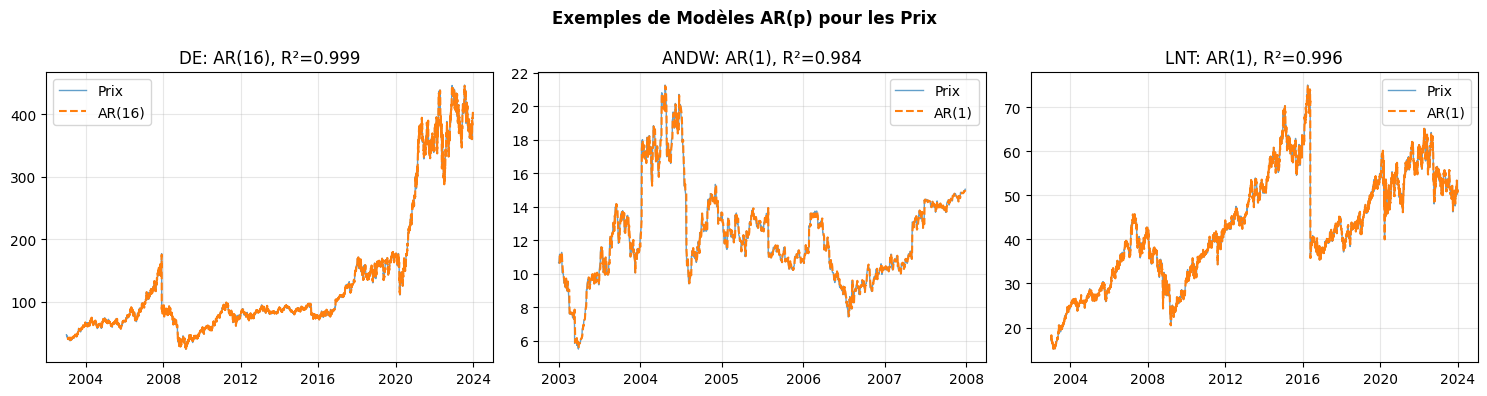

In [ ]:
# VISUALISATION : 3 exemples d'actions

# Sélectionner 3 actions
examples = ar_df.nlargest(1, 'p_bic').iloc[0:1]  # Ordre élevé
examples = pd.concat([examples, ar_df.nsmallest(1, 'p_bic').iloc[0:1]])  # Ordre faible
examples = pd.concat([examples, ar_df.iloc[len(ar_df)//2:len(ar_df)//2+1]])  # Médian

for _, row in examples.iterrows():
    print(f"  {row['ticker']:6s} : AR({int(row['p_bic']):2d}), R²={row['r2']:.3f}, φ₁={row['ar1_coef']:.3f}")

# Graphique simple
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Exemples de Modèles AR(p) pour les Prix', fontweight='bold')

for idx, (_, row) in enumerate(examples.iterrows()):
    ticker = row['ticker']
    p = int(row['p_bic'])
    
    # Série de prix
    series = prices_pivot[ticker].dropna()
    
    # Estimer modèle
    model = AutoReg(series, lags=p, trend='c', old_names=False)
    fit = model.fit()
    
    # Tracer
    axes[idx].plot(series.index, series, label='Prix', linewidth=1, alpha=0.7)
    axes[idx].plot(fit.fittedvalues.index, fit.fittedvalues, 
                   label=f'AR({p})', linewidth=1.5, linestyle='--')
    axes[idx].set_title(f'{ticker}: AR({p}), R²={row["r2"]:.3f}')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [280]:
# QUESTION 4b : Modèles avec RENDEMENTS (au lieu de prix)

# Calculer les rendements forward
returns_data = stats_data[['date', 'ticker', 'price', 'Composite_Ratio', 'TTM_PE', 'forecast_eps_ntm']].copy()
returns_data = returns_data.sort_values(['ticker', 'date'])
returns_data['price_next'] = returns_data.groupby('ticker')['price'].shift(-1)
returns_data['return_forward'] = (returns_data['price_next'] - returns_data['price']) / returns_data['price']
returns_data = returns_data.dropna(subset=['return_forward', 'Composite_Ratio'])

print(f"Observations : {len(returns_data):,}")
print(f"Periode : {returns_data['date'].min()} a {returns_data['date'].max()}")
print()
print("Statistiques rendements :")
print(returns_data['return_forward'].describe())
print()

# Split train/test (80/20)
split_date = returns_data['date'].quantile(0.8)
train = returns_data[returns_data['date'] <= split_date].copy()
test = returns_data[returns_data['date'] > split_date].copy()

print(f"Train : {len(train):,} obs | Test : {len(test):,} obs")
print()

# Modèle de base : OLS
X_train_base = sm.add_constant(train['Composite_Ratio'].values)
y_train = np.array(train['return_forward'].values, dtype=float)
results_base = sm.OLS(y_train, X_train_base).fit()

X_test_base = sm.add_constant(test['Composite_Ratio'].values)
y_test = np.array(test['return_forward'].values, dtype=float)
y_pred_base = results_base.predict(X_test_base)

r2_oos_base = 1 - np.sum((y_test - y_pred_base)**2) / np.sum((y_test - y_test.mean())**2)
rmse_base = np.sqrt(np.mean((y_test - y_pred_base)**2))

print(f"Modele de base (OLS) : R2 = {r2_oos_base:.4f}, RMSE = {rmse_base:.6f}")
print()

# Créer features pour ML
def create_features(df):
    features = pd.DataFrame()
    features['composite_ratio'] = df['Composite_Ratio']
    features['ttm_pe'] = df['TTM_PE']
    features['forecast_eps'] = df['forecast_eps_ntm']
    features['composite_squared'] = df['Composite_Ratio'] ** 2
    features['composite_log'] = np.log(df['Composite_Ratio'].clip(lower=0.01))
    features['pe_squared'] = df['TTM_PE'] ** 2
    features['pe_log'] = np.log(df['TTM_PE'].clip(lower=0.01))
    features['composite_times_pe'] = df['Composite_Ratio'] * df['TTM_PE']
    features['forecast_times_pe'] = df['forecast_eps_ntm'] * df['TTM_PE']
    return features.fillna(0)

X_train_ml = create_features(train)
X_test_ml = create_features(test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_ml)
X_test_scaled = scaler.transform(X_test_ml)

# Ridge
ridge_ret = RidgeCV(alphas=np.logspace(-3, 3, 50), cv=5)
ridge_ret.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_ret.predict(X_test_scaled)
r2_ridge = 1 - np.sum((y_test - y_pred_ridge)**2) / np.sum((y_test - y_test.mean())**2)
rmse_ridge = np.sqrt(np.mean((y_test - y_pred_ridge)**2))
print(f"Ridge : R2 = {r2_ridge:.4f}, RMSE = {rmse_ridge:.6f}")

# LASSO
lasso_ret = LassoCV(alphas=np.logspace(-6, 0, 50), cv=5, max_iter=10000)
lasso_ret.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_ret.predict(X_test_scaled)
r2_lasso = 1 - np.sum((y_test - y_pred_lasso)**2) / np.sum((y_test - y_test.mean())**2)
rmse_lasso = np.sqrt(np.mean((y_test - y_pred_lasso)**2))
print(f"LASSO : R2 = {r2_lasso:.4f}, RMSE = {rmse_lasso:.6f}")

# Elastic Net
elastic_ret = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99], alphas=np.logspace(-6, 0, 50), cv=5, max_iter=10000)
elastic_ret.fit(X_train_scaled, y_train)
y_pred_elastic = elastic_ret.predict(X_test_scaled)
r2_elastic = 1 - np.sum((y_test - y_pred_elastic)**2) / np.sum((y_test - y_test.mean())**2)
rmse_elastic = np.sqrt(np.mean((y_test - y_pred_elastic)**2))
print(f"Elastic Net : R2 = {r2_elastic:.4f}, RMSE = {rmse_elastic:.6f}")
print()

comparison_returns = pd.DataFrame({
    'Modele': ['Base (EPS x P/E)', 'Ridge', 'LASSO', 'Elastic Net'],
    'R2 (Rendements)': [r2_oos_base, r2_ridge, r2_lasso, r2_elastic],
    'RMSE (Rendements)': [rmse_base, rmse_ridge, rmse_lasso, rmse_elastic],
    'R2 (Prix - Q2/Q3)': [0.9300, 0.9314, 0.9302, 0.9300],
    'RMSE (Prix - Q2/Q3)': [17.60, 17.43, 17.58, 17.60]
})

print(comparison_returns.to_string(index=False))

Observations : 171,262
Periode : 2003-08-28 00:00:00 a 2023-12-28 00:00:00

Statistiques rendements :
count   171,262.0000
mean          0.0005
std           0.0233
min          -0.7615
25%          -0.0084
50%           0.0005
75%           0.0094
max           3.0352
Name: return_forward, dtype: Float64

Train : 137,020 obs | Test : 34,242 obs

Modele de base (OLS) : R2 = -0.0013, RMSE = 0.024140

Ridge : R2 = -0.0006, RMSE = 0.024132
LASSO : R2 = -0.0003, RMSE = 0.024129
Elastic Net : R2 = -0.0003, RMSE = 0.024129

          Modele  R2 (Rendements)  RMSE (Rendements)  R2 (Prix - Q2/Q3)  RMSE (Prix - Q2/Q3)
Base (EPS x P/E)          -0.0013             0.0241             0.9300              17.6000
           Ridge          -0.0006             0.0241             0.9314              17.4300
           LASSO          -0.0003             0.0241             0.9302              17.5800
     Elastic Net          -0.0003             0.0241             0.9300              17.6000


In [282]:
# TRANSFORMATION DES DONNÉES POUR CORRIGER LA NON-STATIONNARITÉ

# Utiliser les données ml_complete existantes
data_stationary = ml_complete.copy()

# 1. Transformation logarithmique des prix
data_stationary['log_price'] = np.log(data_stationary['price'])

# 2. Différences logarithmiques (équivalent aux rendements)
data_stationary = data_stationary.sort_values(['ticker', 'date'])
data_stationary['price_diff_log'] = data_stationary.groupby('ticker')['log_price'].diff()

# 3. Moyenne mobile du prix (20 périodes)
data_stationary['price_ma20'] = data_stationary.groupby('ticker')['price'].transform(lambda x: x.rolling(20, min_periods=1).mean())

# 4. Prix détrend (prix - moyenne mobile)
data_stationary['price_detrended'] = data_stationary['price'] - data_stationary['price_ma20']

# Supprimer les NaN créés par les transformations
data_stationary = data_stationary.dropna(subset=['price_diff_log', 'price_detrended'])

print(f"Observations après transformation : {len(data_stationary):,}")
print()
print("Transformations appliquées :")
print("  1. log(price) → Réduction de l'échelle")
print("  2. Delta log(price) → Différences logarithmiques (≈ rendements)")
print("  3. Price - MA(20) → Élimination de la tendance")
print()
print("Statistiques des transformations :")
print(data_stationary[['price', 'log_price', 'price_diff_log', 'price_detrended']].describe())

Observations après transformation : 154,568

Transformations appliquées :
  1. log(price) → Réduction de l'échelle
  2. Delta log(price) → Différences logarithmiques (≈ rendements)
  3. Price - MA(20) → Élimination de la tendance

Statistiques des transformations :
             price    log_price  price_diff_log  price_detrended
count 154,568.0000 154,568.0000    154,568.0000     154,568.0000
mean       71.5940       4.0326          0.0002           0.1980
std        52.0450       0.7080          0.0233           3.8545
min         4.1400       1.4207         -0.7262         -70.2410
25%        36.0700       3.5855         -0.0083          -0.9950
50%        57.7100       4.0554          0.0005           0.2290
75%        89.5700       4.4950          0.0092           1.5300
max       401.6400       5.9956          1.3950          97.2620


In [ ]:
# MODÈLE AVEC PRIX DÉTRENDÉ (Prix - Moyenne Mobile)

# Split train/test (même ratio que précédemment)
split_date_st = data_stationary['date'].quantile(0.8)
train_st = data_stationary[data_stationary['date'] <= split_date_st].copy()
test_st = data_stationary[data_stationary['date'] > split_date_st].copy()

if 'composite_ratio' in data_stationary.columns:
    feature_cols_simple = ['composite_ratio', 'ttm_pe', 'forecast_eps']
elif 'eps_forecast' in data_stationary.columns:
    feature_cols_simple = ['eps_forecast', 'pe_ttm', 'eps_times_pe']
else:
    numeric_cols = data_stationary.select_dtypes(include=[np.number]).columns.tolist()
    feature_cols_simple = [c for c in numeric_cols if c not in ['price', 'log_price', 'price_diff_log', 'price_detrended', 'price_ma20']][:3]

X_train_st = train_st[feature_cols_simple].values
X_test_st = test_st[feature_cols_simple].values

# Variable cible : Prix détrendé
y_train_st = train_st['price_detrended'].values
y_test_st = test_st['price_detrended'].values

# Standardisation
scaler_st = StandardScaler()
X_train_st_scaled = scaler_st.fit_transform(X_train_st)
X_test_st_scaled = scaler_st.transform(X_test_st)

# Entraînement Ridge
ridge_st = RidgeCV(alphas=np.logspace(-3, 3, 50), cv=5)
ridge_st.fit(X_train_st_scaled, y_train_st)

# Prédictions
y_pred_st = ridge_st.predict(X_test_st_scaled)

# Métriques
r2_st = 1 - np.sum((y_test_st - y_pred_st)**2) / np.sum((y_test_st - y_test_st.mean())**2)
rmse_st = np.sqrt(np.mean((y_test_st - y_pred_st)**2))

In [290]:
# MODÈLE AVEC DIFFÉRENCES LOGARITHMIQUES

# Variable cible : Différences logarithmiques (rendements approx.)
y_train_log = train_st['price_diff_log'].values
y_test_log = test_st['price_diff_log'].values

# Entraînement Ridge
ridge_log = RidgeCV(alphas=np.logspace(-3, 3, 50), cv=5)
ridge_log.fit(X_train_st_scaled, y_train_log)

# Prédictions
y_pred_log = ridge_log.predict(X_test_st_scaled)

# Métriques
r2_log = 1 - np.sum((y_test_log - y_pred_log)**2) / np.sum((y_test_log - y_test_log.mean())**2)
rmse_log = np.sqrt(np.mean((y_test_log - y_pred_log)**2))

In [292]:
# TABLEAU COMPARATIF DES TRANSFORMATIONS

r2_ridge_original = 0.9314
rmse_ridge_original = 17.43

comparison_stat = pd.DataFrame({
    'Approche': [
        'Prix bruts (Q2-Q3)',
        'Prix détrendé (- MA20)',
        'Différences log (rendements)'
    ],
    'Variable_cible': [
        'Price',
        'Price - MA(20)',
        'Δlog(Price)'
    ],
    'R²': [r2_ridge_original, r2_st, r2_log],
    'RMSE': [rmse_ridge_original, rmse_st, rmse_log],
    'Stationnaire': ['Non', 'Oui', 'Oui']
})

comparison_stat

,Approche,Variable_cible,R²,RMSE,Stationnaire
0,Prix bruts (Q2-Q3),Price,0.9314,17.4300,Non
1,Prix détrendé (- MA20),Price - MA(20),0.0176,5.6353,Oui
2,Différences log (rendements),Δlog(Price),0.0008,0.0254,Oui
